In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/UKCOVID


In [3]:
paths ={
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70metadata.tsv',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70RNA_and_ADT.TP10K.h5ad',
 # 'WNN_UMAP': ''
}

# Run cNMF

In [4]:
cnmfdir = '../../../Data/PerDataset/UKCOVID'
name = 'UKCOVID.20231005'

In [4]:
! ls ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/cnmf_tmp

ls: cannot access ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/cnmf_tmp: No such file or directory


In [11]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(15, 55)
n_iter = 20
num_per_node = 5

In [7]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [7]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [10]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

160

In [11]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J UKCOVID.20231005 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.0.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name UKCOVID.20231005 --output-dir ../../../Data/PerDataset/UKCOVID --total-workers 160 --worker-index 0"
Job <884031> is submitted to queue <short>.
bsub -q short -J UKCOVID.20231005 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.1.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --na

In [ ]:
! bjobs | wc -l

In [ ]:
total_workers = int((len(Ks)*n_iter))
total_workers

In [27]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

In [28]:
len(missing)

0

In [ ]:
! bjobs | wc -l

In [25]:
cnmfdir, name

('../../../Data/PerDataset/UKCOVID', 'UKCOVID.20231005')

In [26]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q medium -J UKCOVID.20231005 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.358.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.358.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name UKCOVID.20231005 --output-dir ../../../Data/PerDataset/UKCOVID --total-workers 800 --worker-index 358"
Job <887268> is submitted to queue <medium>.
bsub -q medium -J UKCOVID.20231005 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.505.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/log/UKCOVID.20231005.505.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf f

In [29]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizations for k=38.
Combining factorizations for k=39.
Combining factorizations for k=40.
Combining factorizations for k=41.
Combining factorizations for k=42.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 3h 22min 43s, sys: 3h 33min 55s, total: 6h 56min 39s
Wall time: 18min 3s


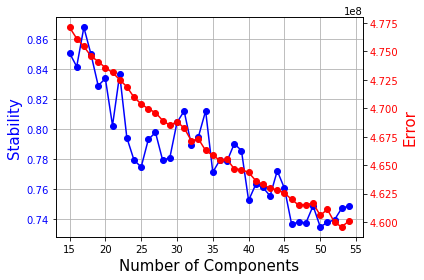

In [30]:
%%time
cnmf_obj.k_selection_plot()

In [8]:
figdir = '../../../Figures/Components'

In [9]:
cmd = 'cp {} {}'.format(cnmf_obj.paths['k_selection_plot'], 
                           os.path.join(figdir, '%s.k_selection.png' % name))

print(cmd)

cp ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/UKCOVID.20231005.k_selection.png ../../../Figures/Components/UKCOVID.20231005.k_selection.png


In [10]:
print(cmd)
! {cmd}

cp ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005/UKCOVID.20231005.k_selection.png ../../../Figures/Components/UKCOVID.20231005.k_selection.png


In [17]:
kthresh = {30:.2, 31:.2, 34:.2, 38:.2, 39:.2, 44:.2, 45:.2}

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


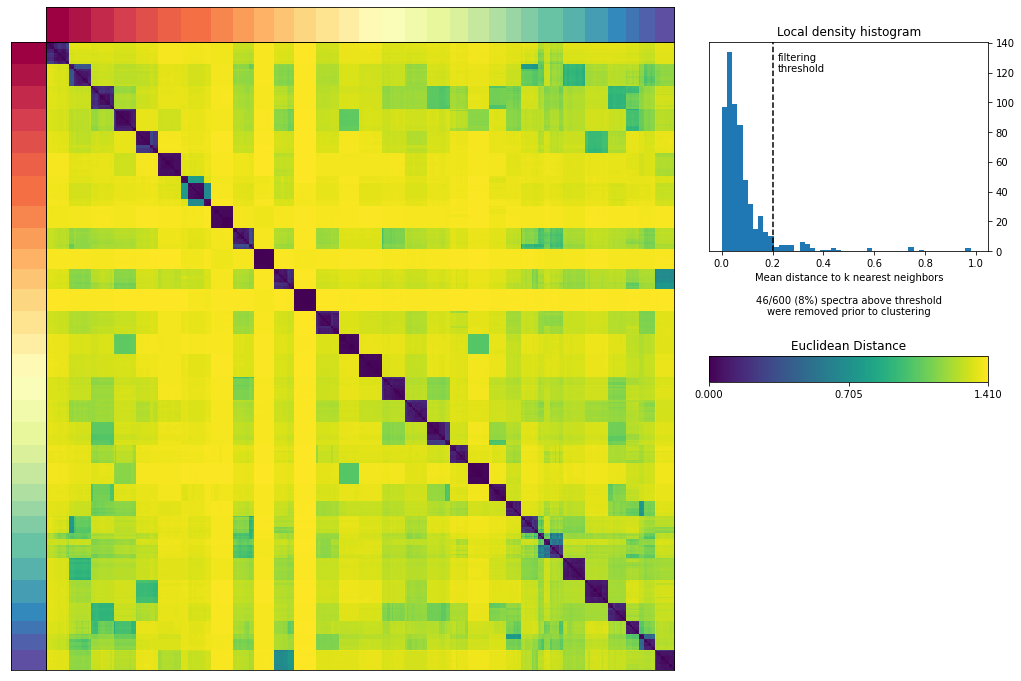

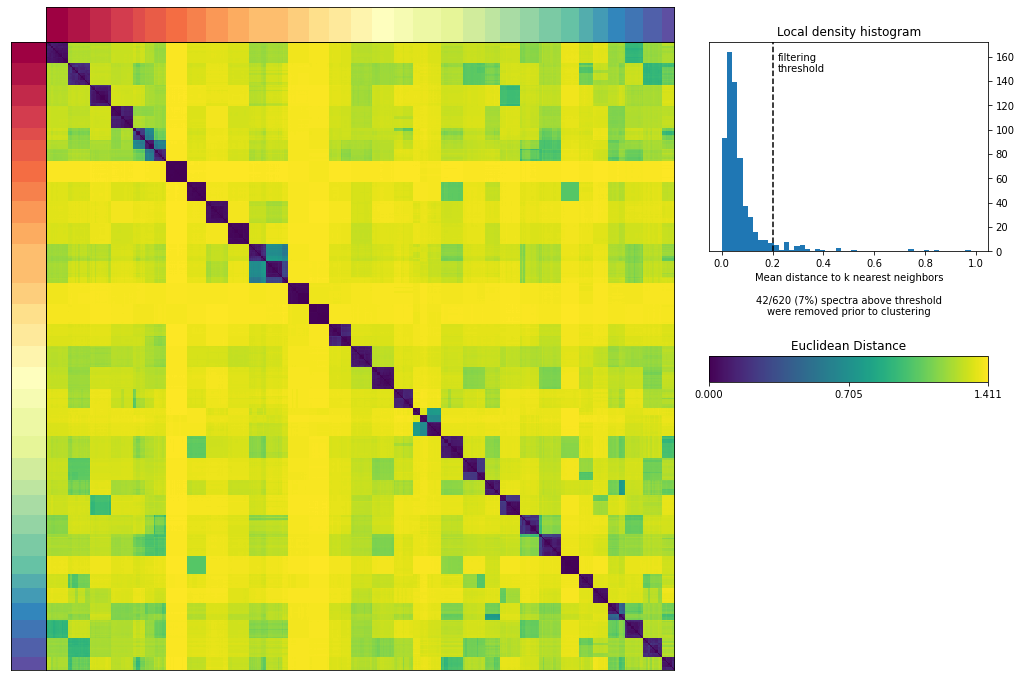

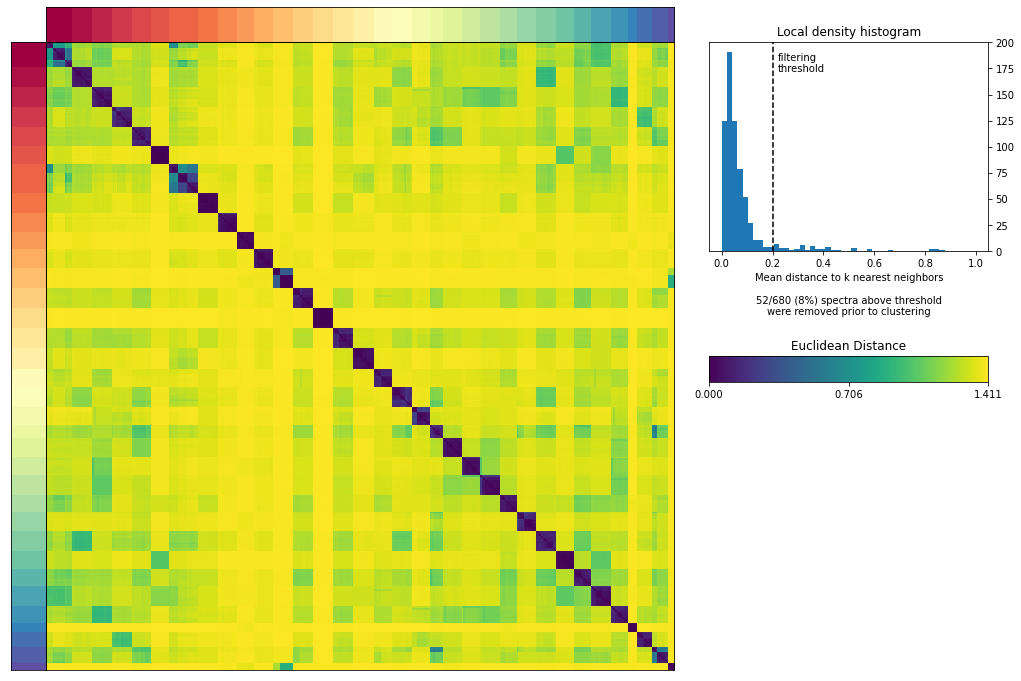

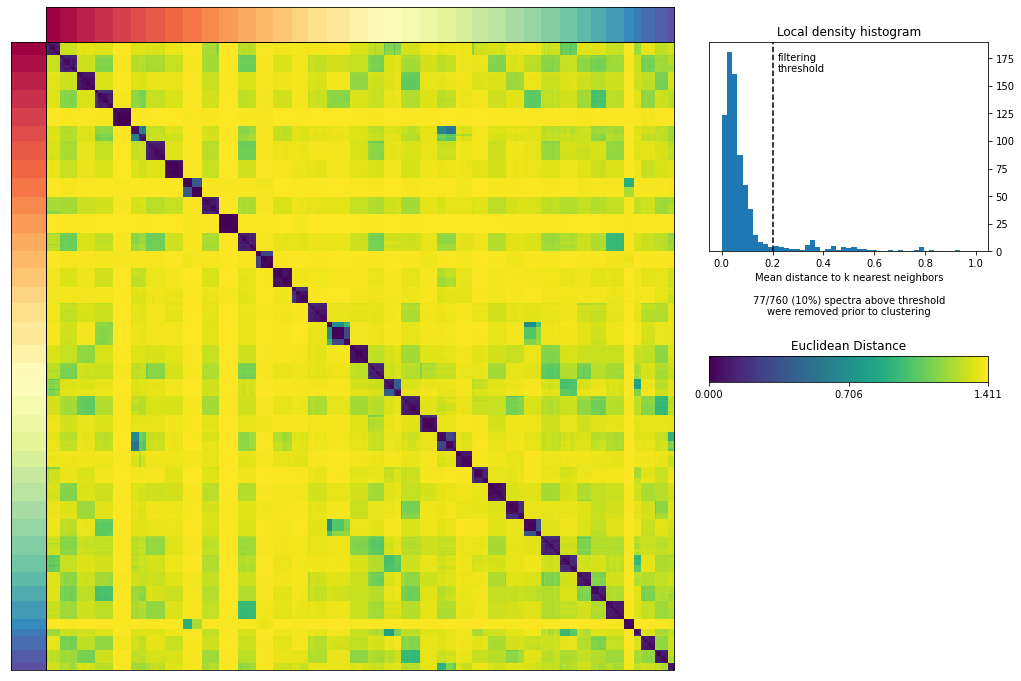

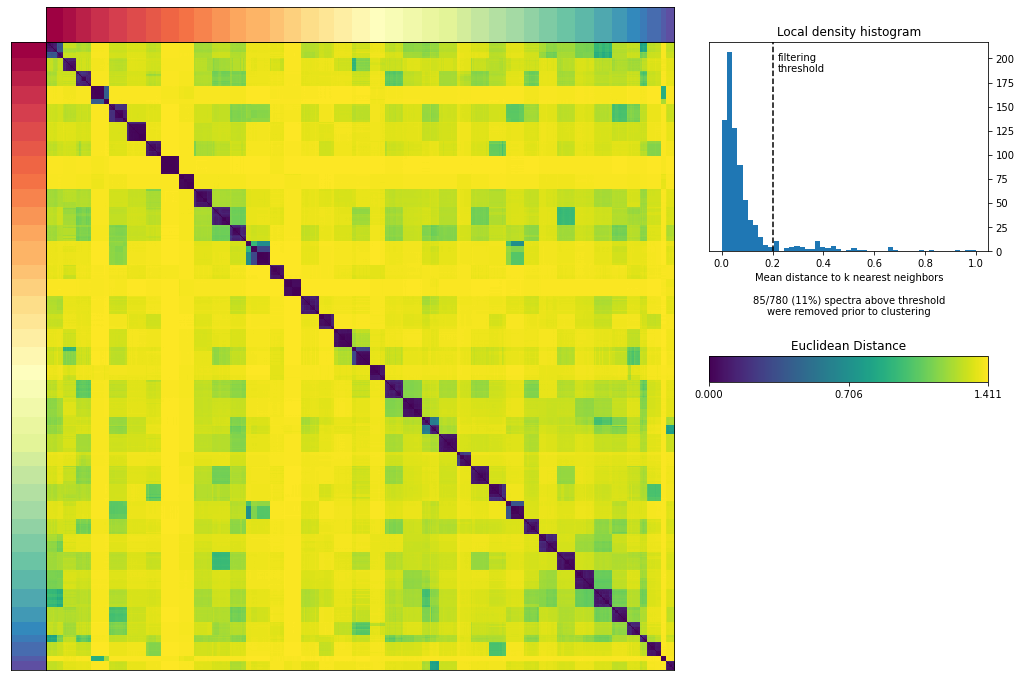

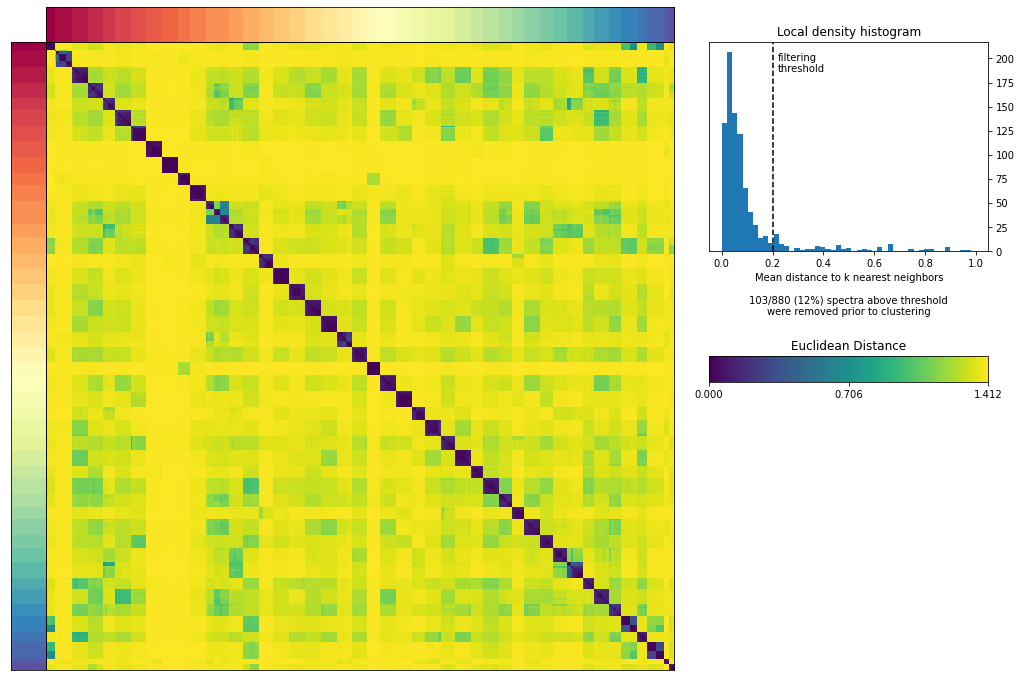

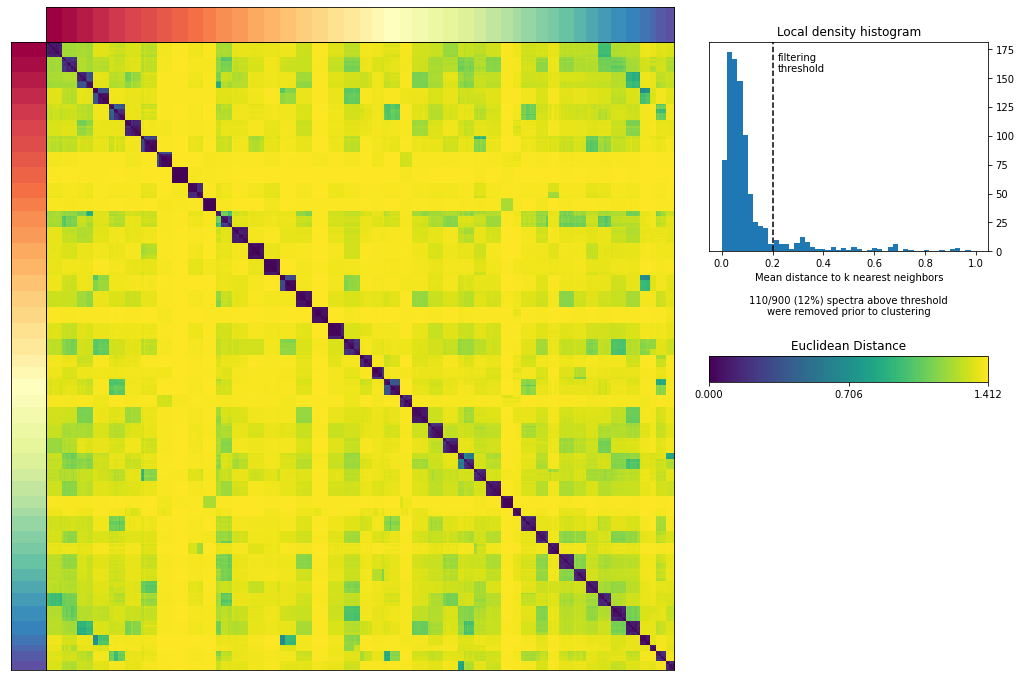

In [32]:
for k in kthresh.keys():
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

## Compare with original TCATs

In [13]:
metagepinfo = read_dataset_log(tabname='Current Meta-program Paths').loc[0,:]
metagepinfo

clustering_fn                      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                        /data/srlab1/TCAT/Data/TCAT/MergedHVG.UnionAll...
tpm_norm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_norm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                     /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
Name: 0, dtype: object

In [14]:
clustering = pd.read_csv(metagepinfo.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
clustering.head()

AMP-RA  \
CellCycle-G2M_CellCycle_G2M                  AMP-RA:CellCycle-G2M   
ISG                                                    AMP-RA:ISG   
gdT                                                           NaN   
Metallothionein                            AMP-RA:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  AMP-RA:CellCycle-Sphase   

                                                          UK-Covid  \
CellCycle-G2M_CellCycle_G2M                 UK-Covid:CellCycle_G2M   
ISG                                                   UK-Covid:ISG   
gdT                                                   UK-Covid:gdT   
Metallothionein                           UK-Covid:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      UK-Covid:CellCycle_S   

                                                           Pan-Tissue  \
CellCycle-G2M_CellCycle_G2M                  Pan-Tissue:CellCycle-G2M   
ISG                                                    Pan-Tissue:ISG   
gdT                                                               NaN   
Metallothionein                            Pan-Tissue:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Tissue:CellCycle-Sphase   

                                                        HIV-Vaccine  \
CellCycle-G2M_CellCycle_G2M               HIV-Vaccine:CellCycle_G2M   
ISG                                                 HIV-Vaccine:ISG   
gdT                                                 HIV-Vaccine:gdT   
Metallothionein                                                 NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    HIV-Vaccine:CellCycle_S   

                                                          COMBAT  \
CellCycle-G2M_CellCycle_G2M                 COMBAT:CellCycle_G2M   
ISG                                                   COMBAT:ISG   
gdT                                                   COMBAT:gdT   
Metallothionein                           COMBAT:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      COMBAT:CellCycle_S   

                                                        TBRU  \
CellCycle-G2M_CellCycle_G2M               TBRU:CellCycle_G2M   
ISG                                                 TBRU:ISG   
gdT                                                 TBRU:gdT   
Metallothionein                                          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    TBRU:DTL/FAM111B   

                                                           Pan-Cancer  
CellCycle-G2M_CellCycle_G2M                  Pan-Cancer:CellCycle-G2M  
ISG                                                    Pan-Cancer:ISG  
gdT                                                               NaN  
Metallothionein                            Pan-Cancer:Metallothionein  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Cancer:CellCycle-Sphase

In [15]:
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T

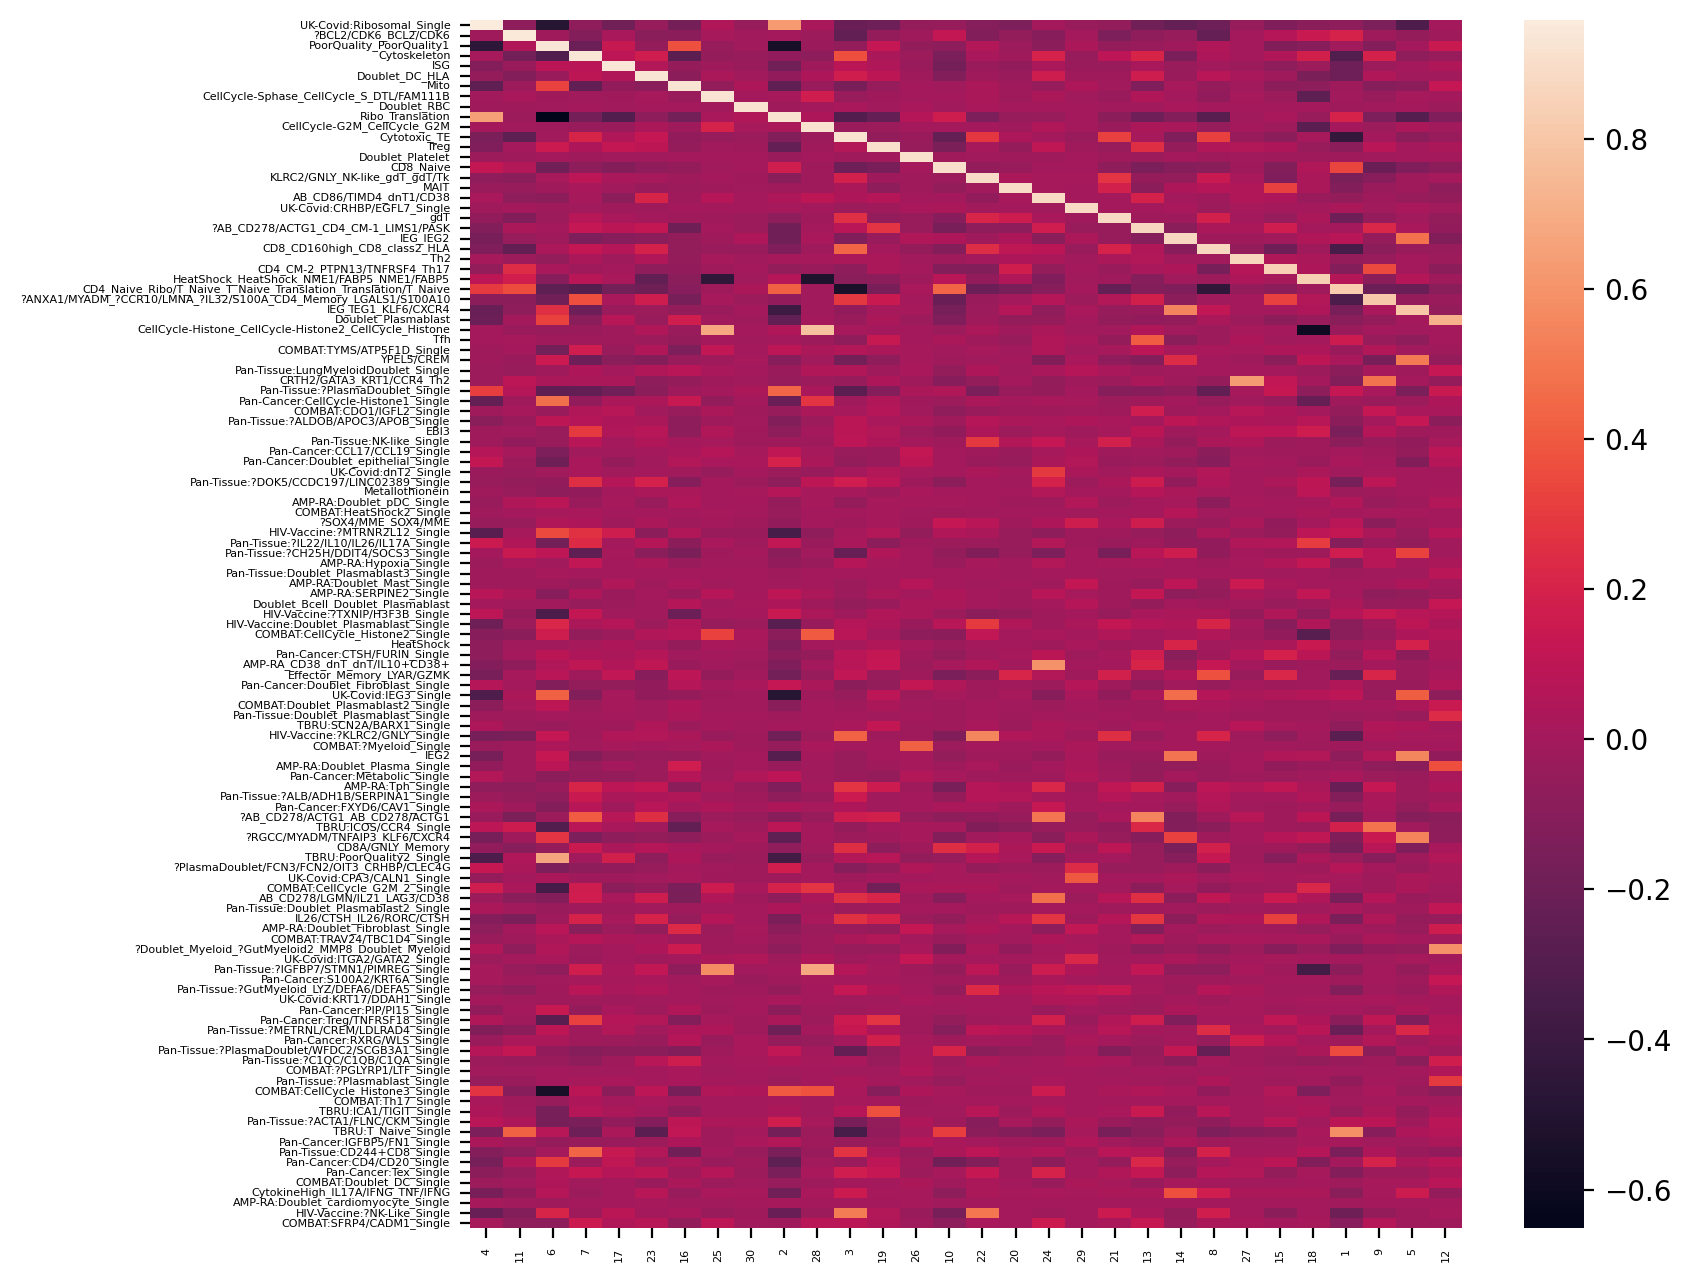

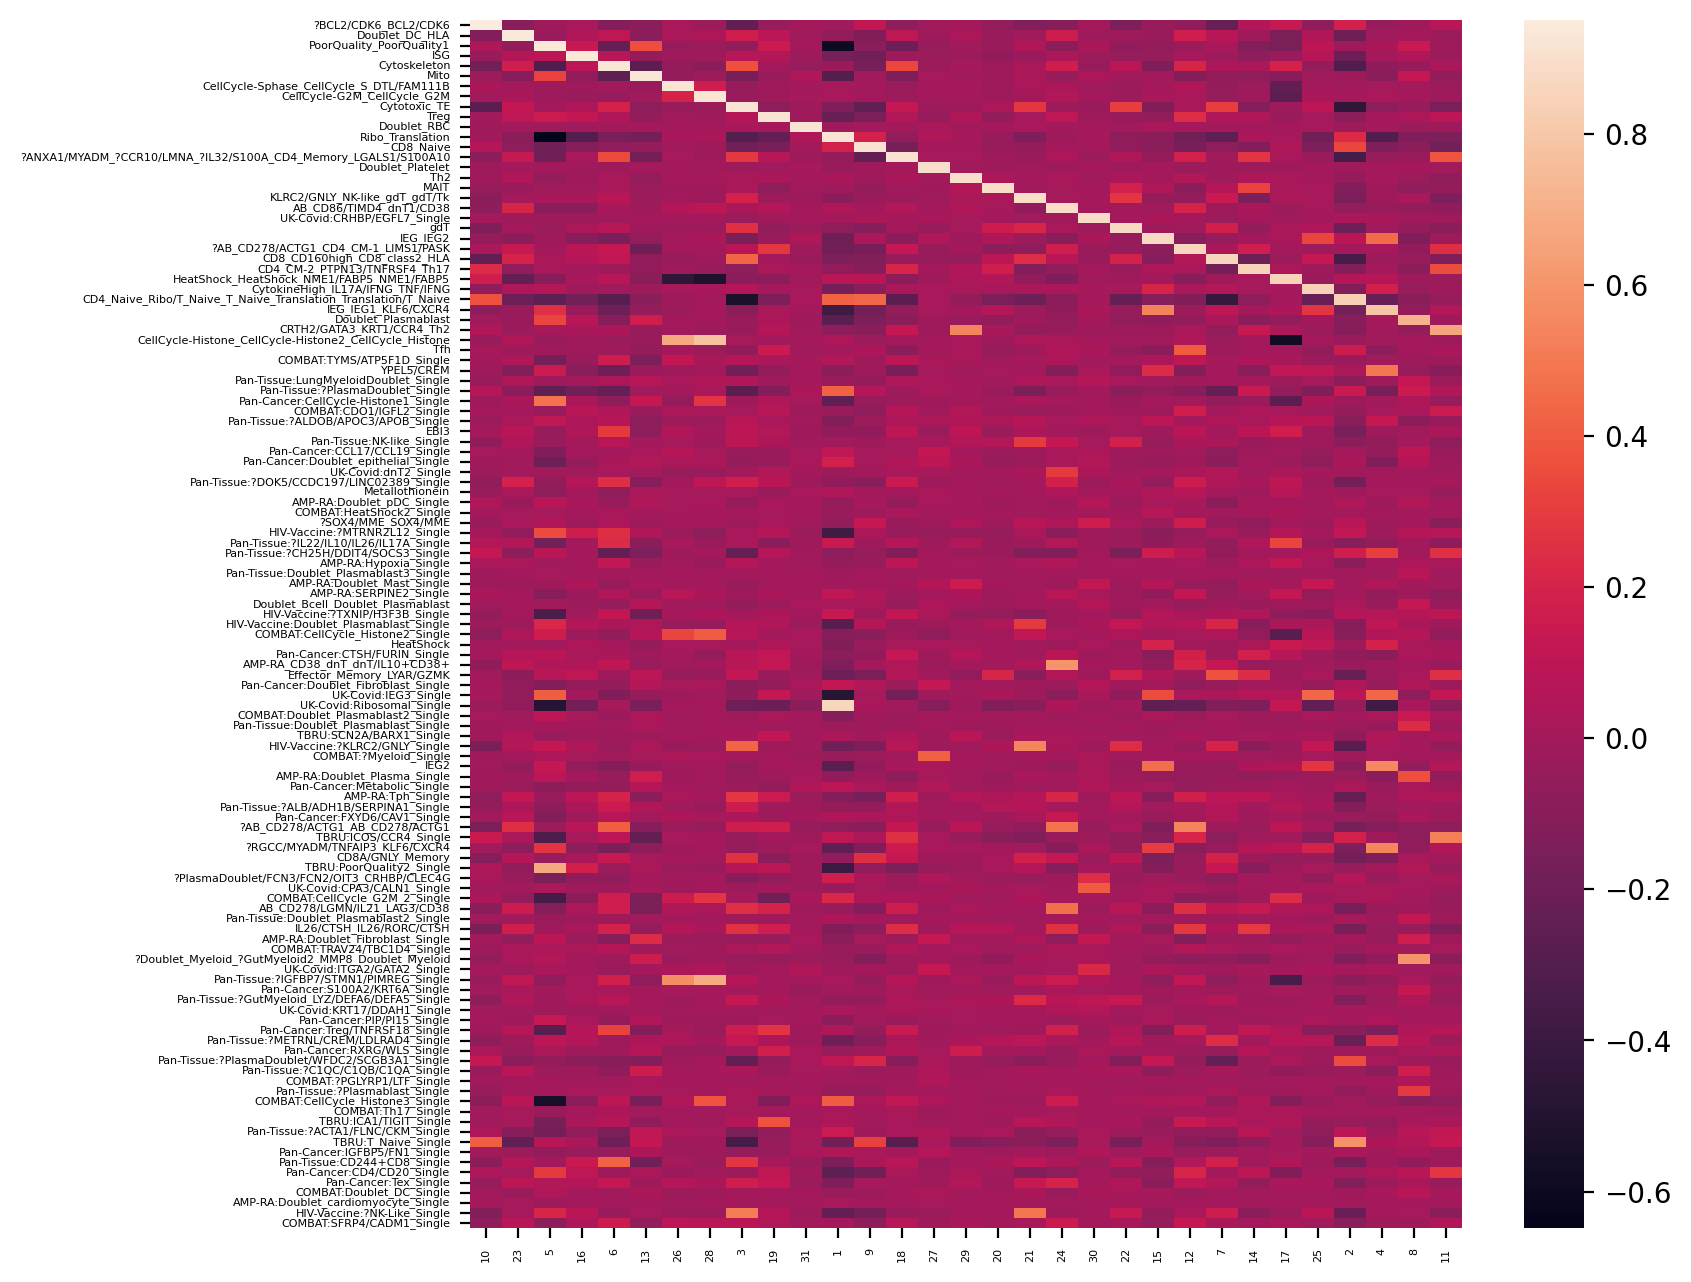

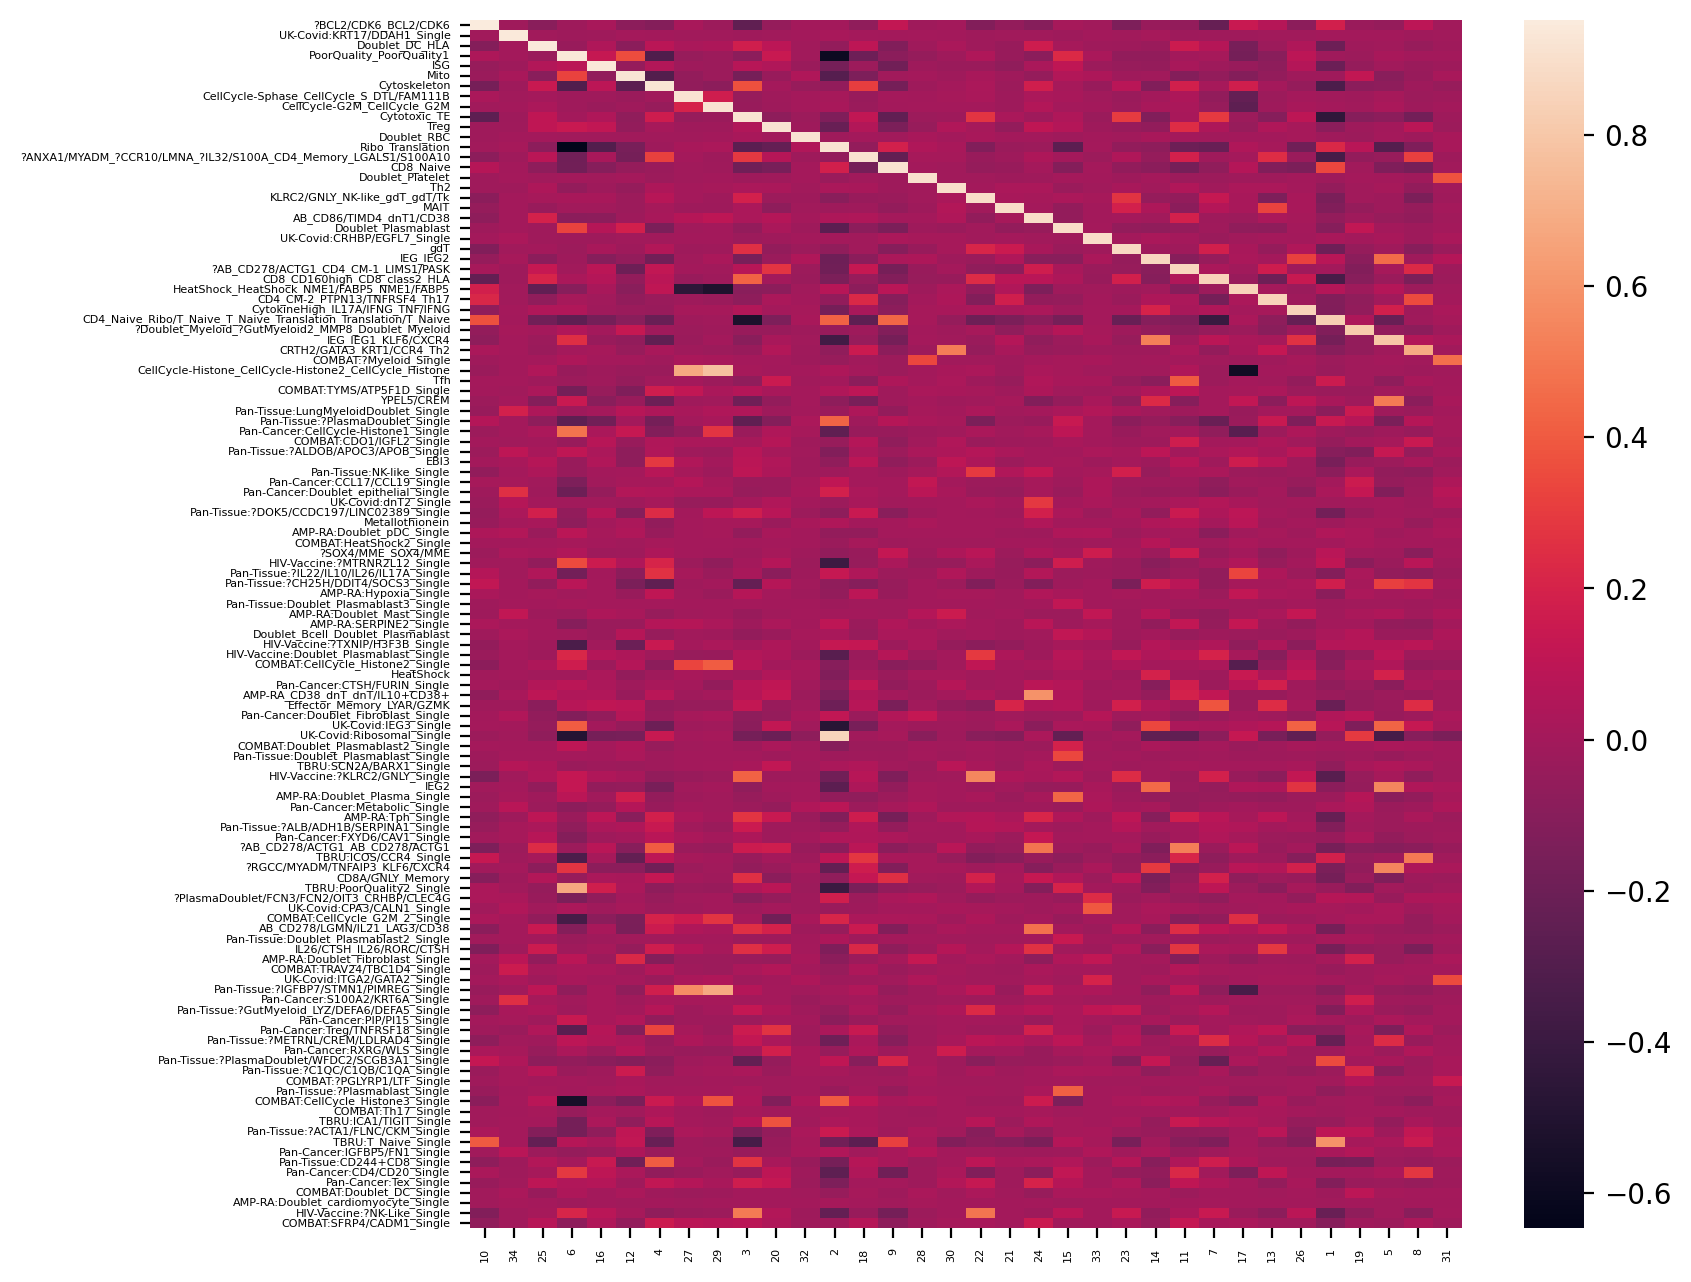

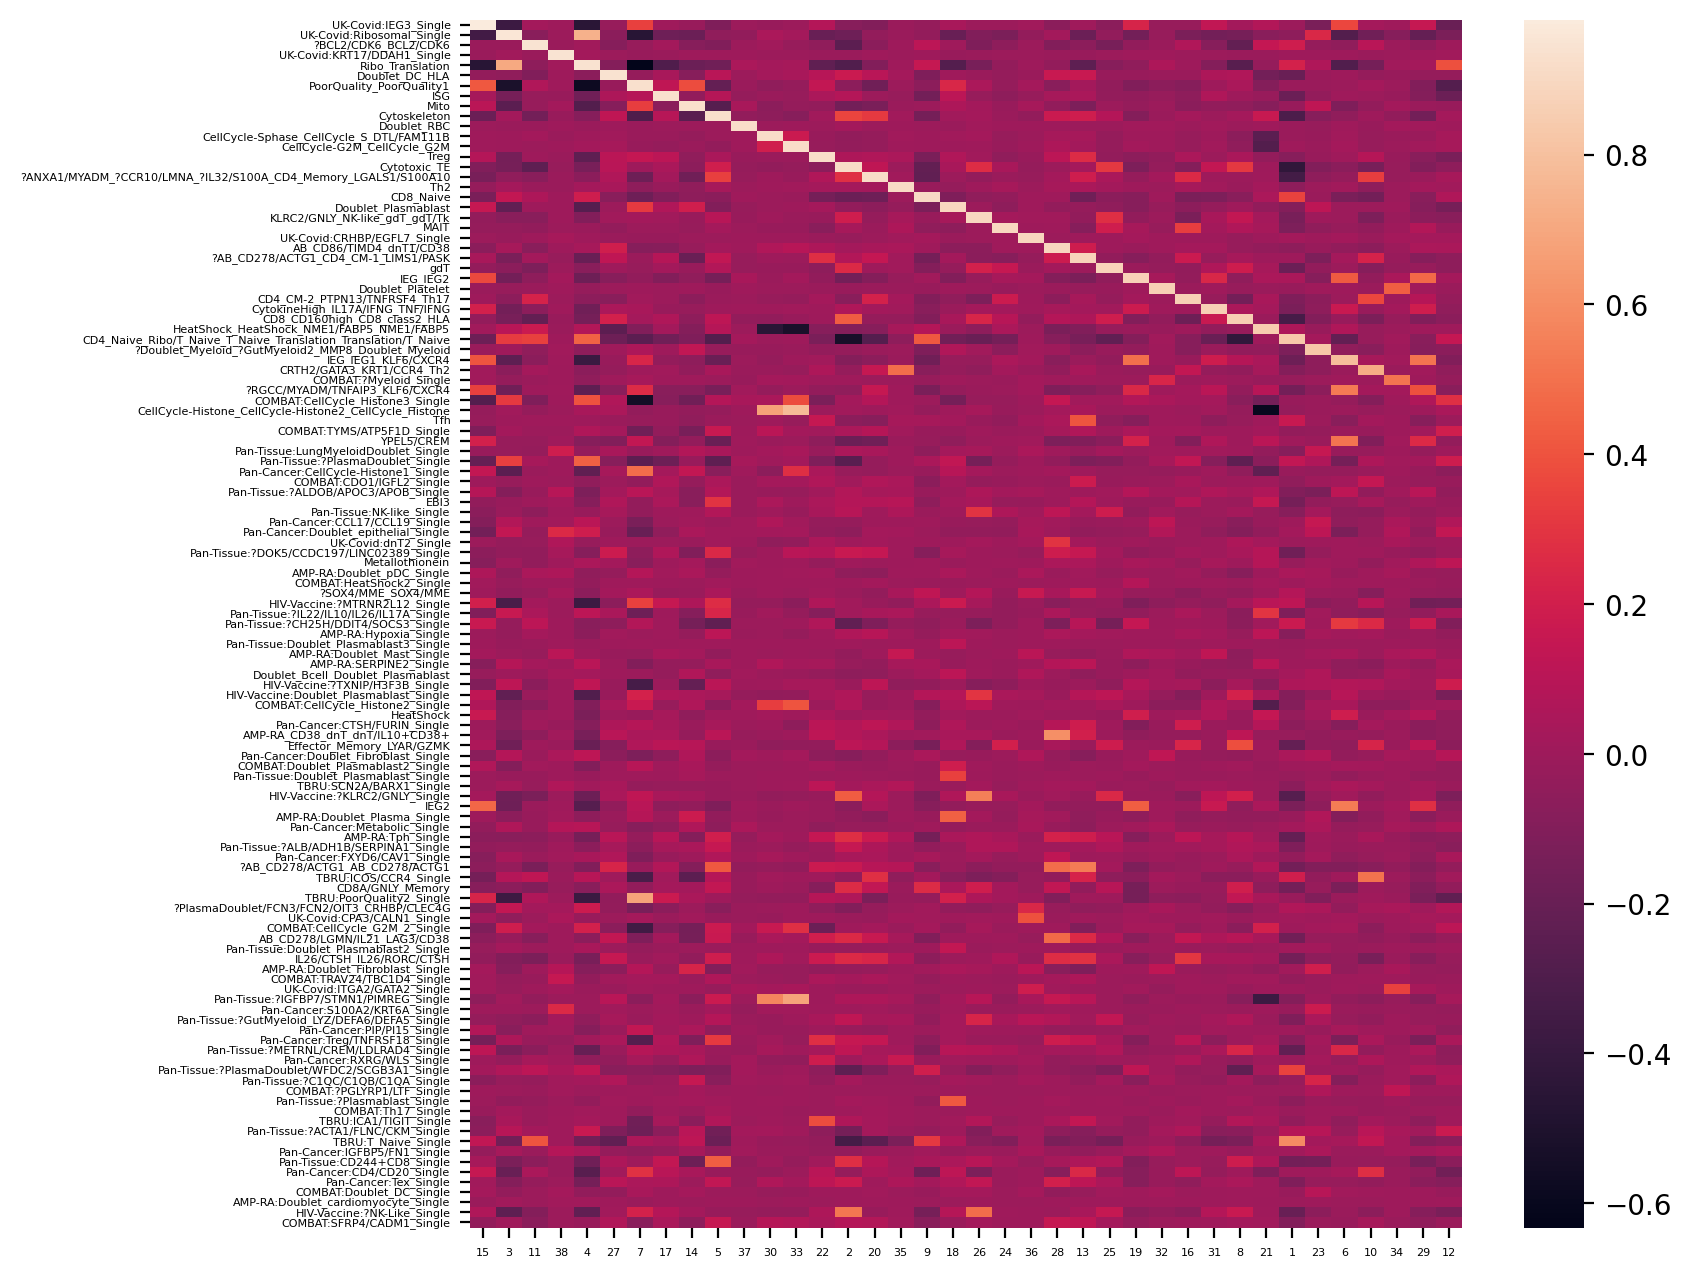

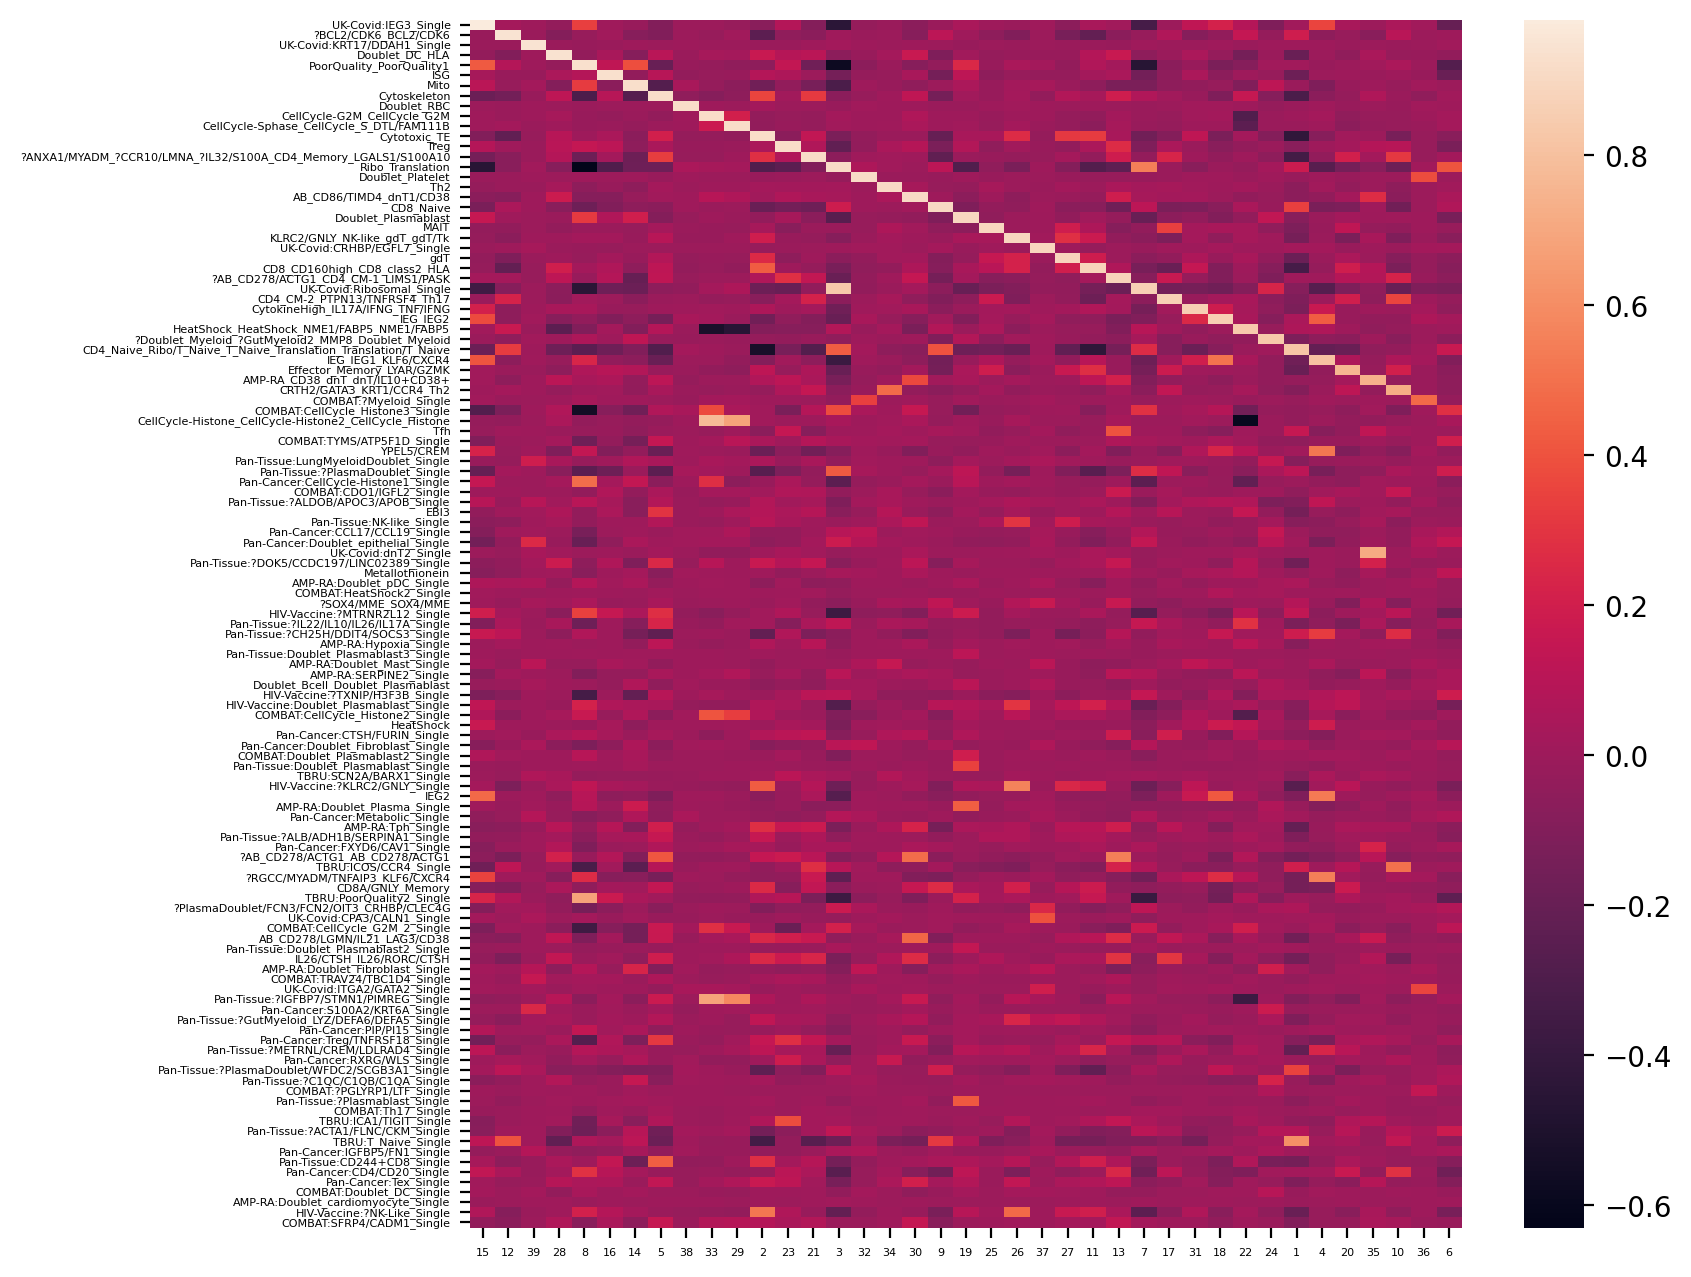

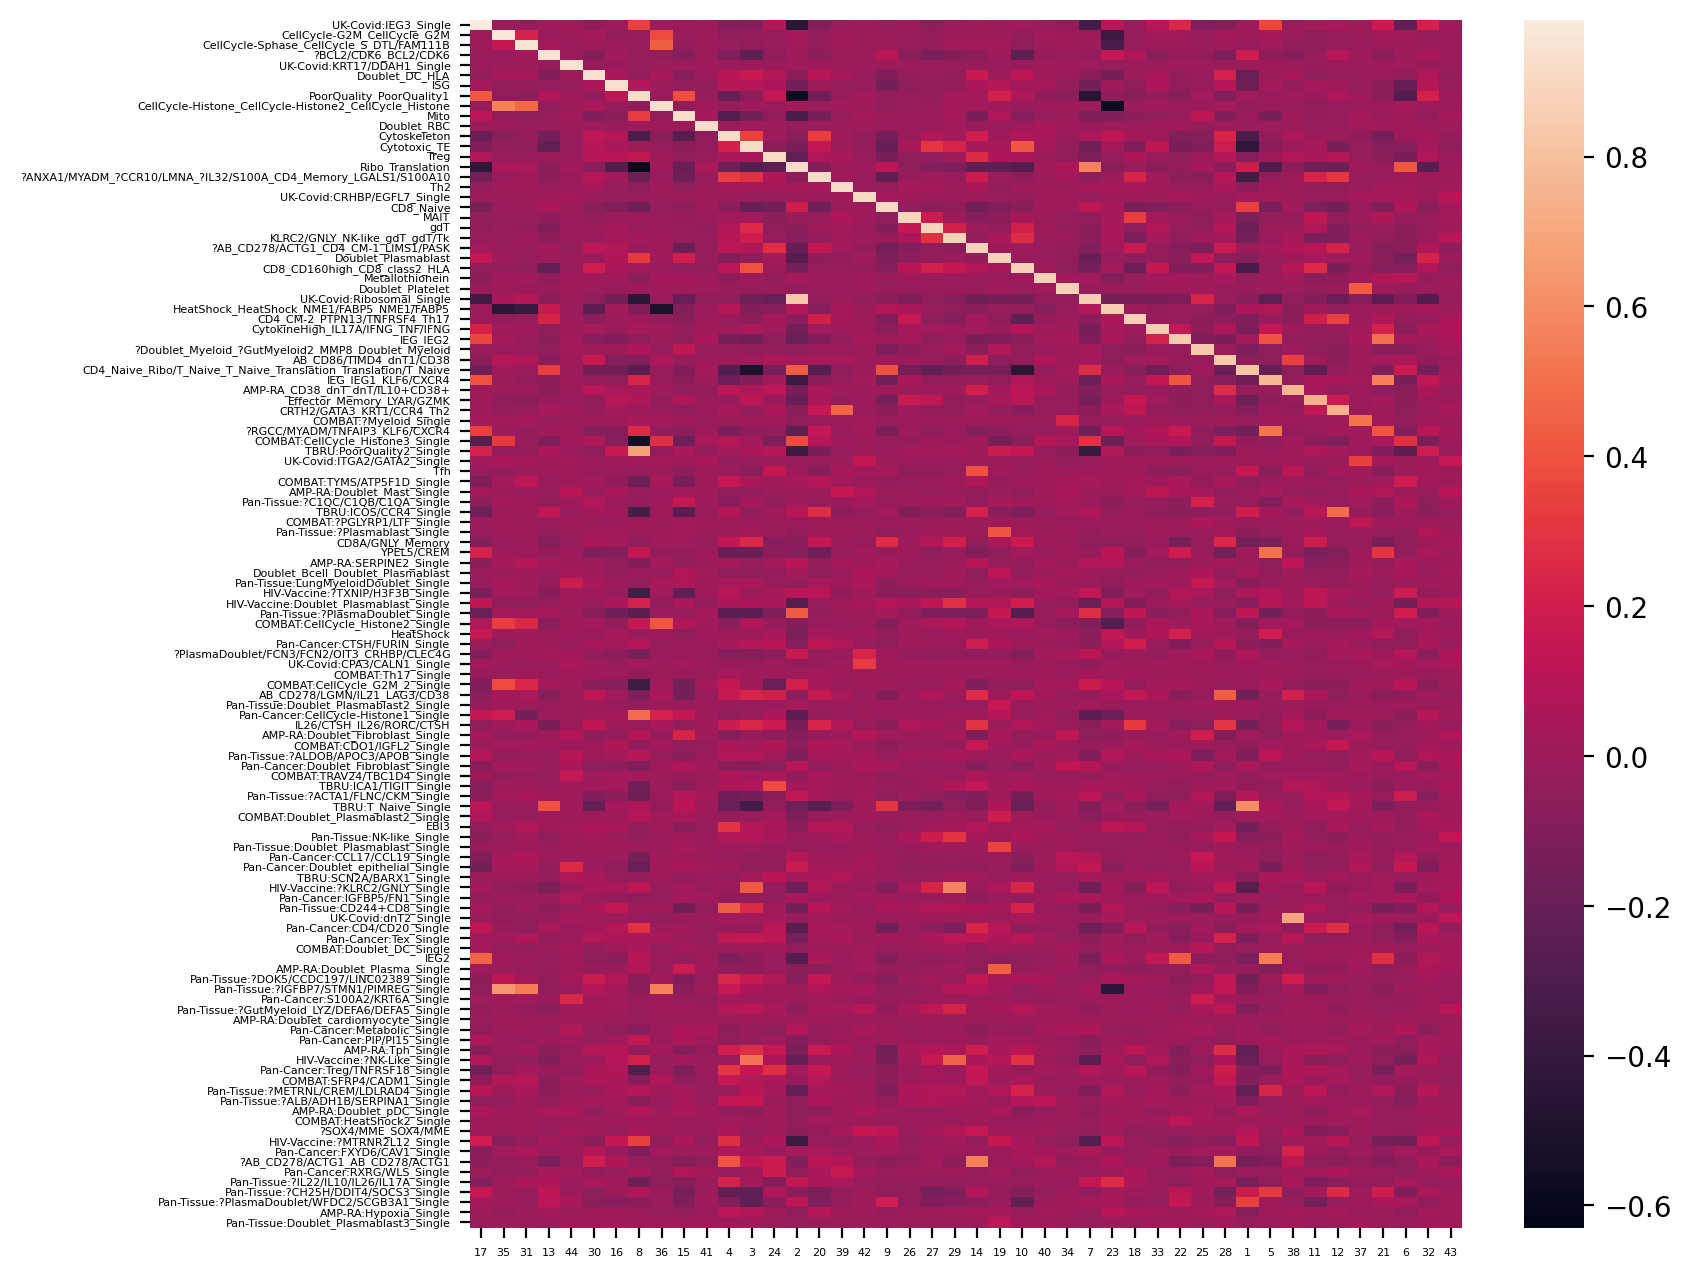

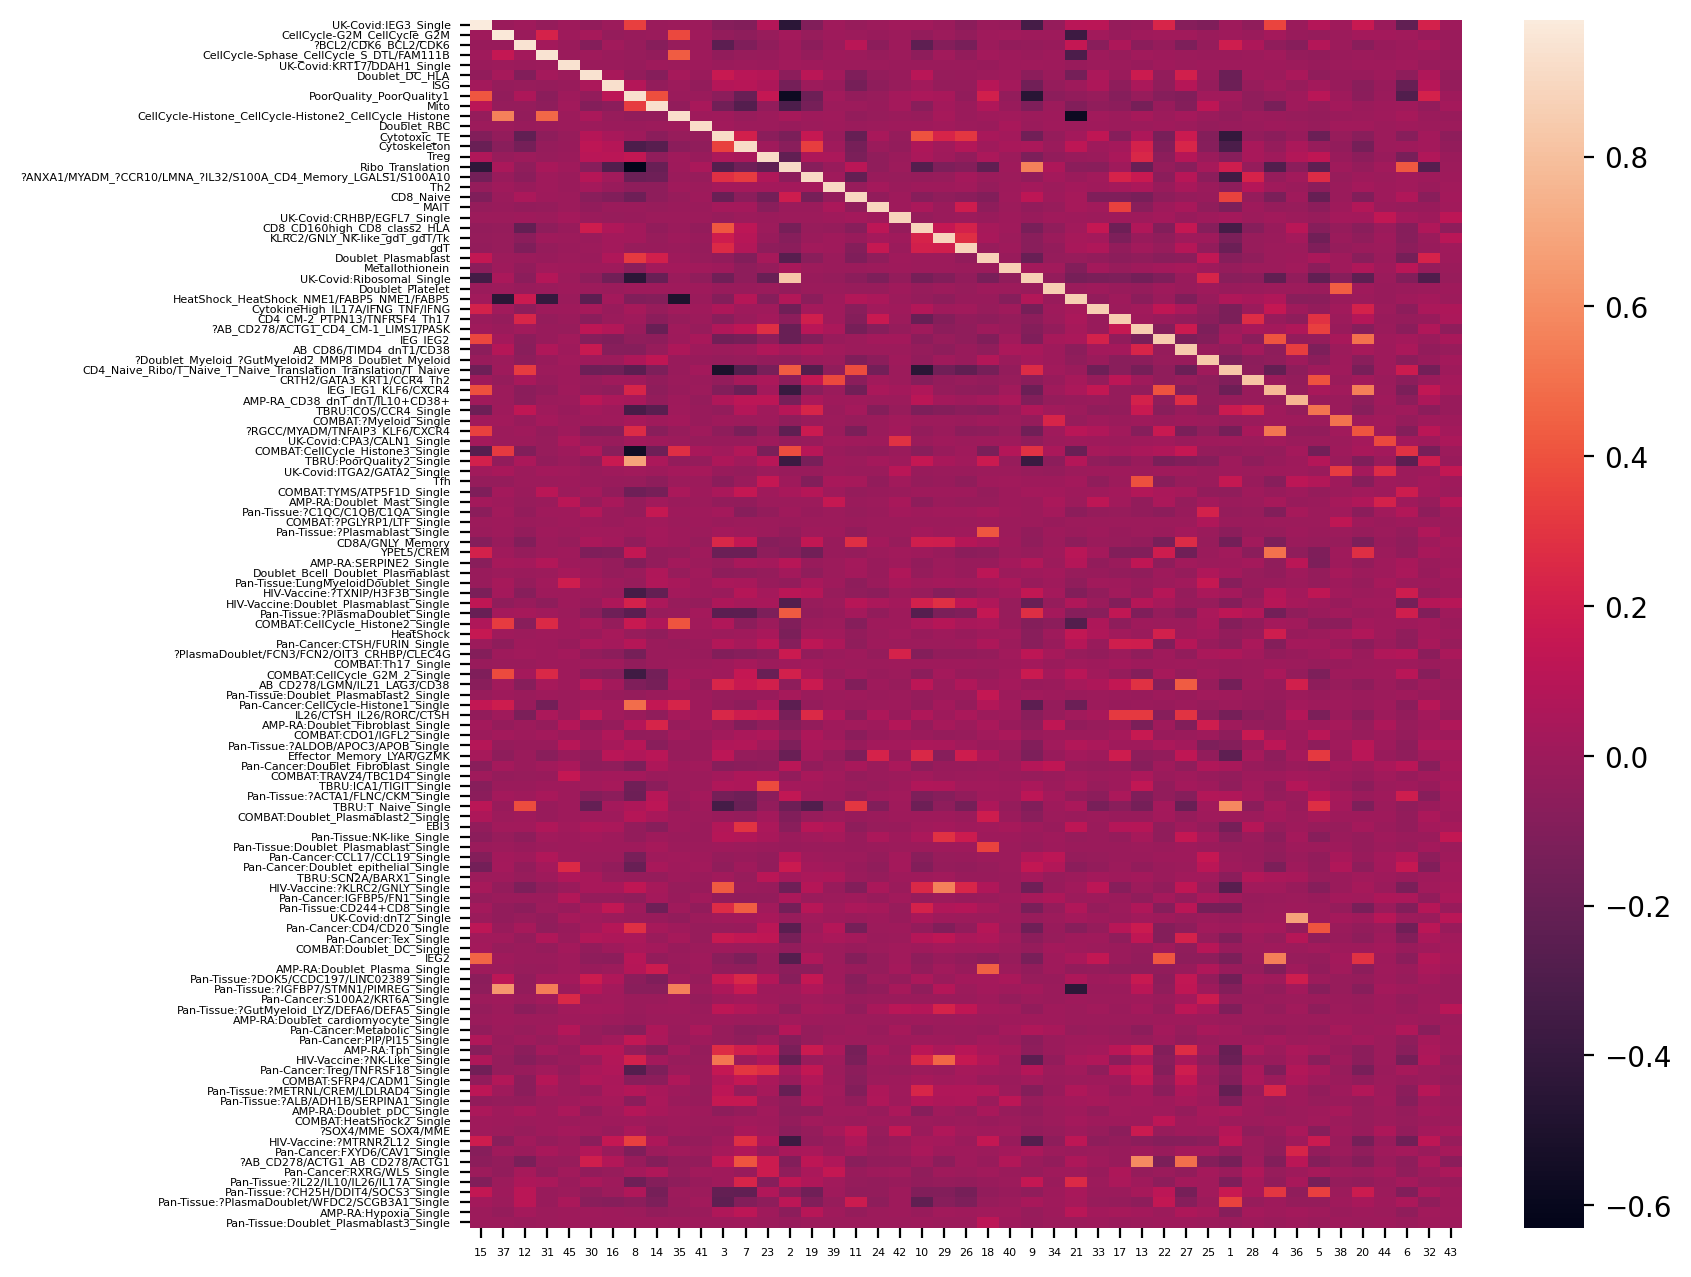

In [18]:
res = []
R_thresh = 0.55
dataset_cols = ['AMP-RA', 'UK-Covid', 'Pan-Tissue', 'HIV-Vaccine', 'COMBAT', 'TBRU', 'Pan-Cancer']
this_datset = 'UK-Covid'
other_dataset_cols = list(set(dataset_cols) - set([this_datset]))
mapping_ref = {}
top_genes_relabeled = {}

for k in kthresh.keys():
    (usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
    overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
    mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
    R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
    rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
    top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
    top_genes_relabeled[k] = top_genes

    fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
    sns.heatmap(R_for_plot, ax=ax)
    ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
    ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
    ax.set_xticklabels(R_for_plot.columns, fontsize=4)
    ax.set_yticklabels(R_for_plot.index, fontsize=4)

    merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
    mapping_ref[k] = merge_annotation
    total_overlaps = (merge_annotation['R']>R_thresh).sum()
    ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
    nonsingleton_overlaps = ind.sum()
    this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
    recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
    new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
    res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])


In [19]:
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  30                30                             28   
1  31                31                             30   
2  34                33                             31   
3  38                35                             31   
4  39                37                             33   
5  44                39                             35   
6  45                38                             34   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                             7                      2               0   
1                             7                      1               0   
2                             7                      2               1   
3                             7                      4               3   
4                             7                      4               2   
5                             7                      4               5   
6                             7                      4               7   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  
5                                       0  
6                                       0

In [20]:
set(mapping_ref[31].loc[mapping_ref[31]['R']>R_thresh, 'X_columns']) - set(mapping_ref[30].loc[mapping_ref[30]['R']>R_thresh, 'X_columns'])


{'CRTH2/GATA3_KRT1/CCR4_Th2', 'CytokineHigh_IL17A/IFNG_TNF/IFNG'}

In [24]:
set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns']) - set(mapping_ref[31].loc[mapping_ref[31]['R']>R_thresh, 'X_columns'])


{'?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid',
 'UK-Covid:KRT17/DDAH1_Single'}

In [25]:
top_genes_relabeled[34]['UK-Covid:KRT17/DDAH1_Single'].head(30)

0        KRT17
1        KRT19
2        DDAH1
3      S100A16
4         KRT7
5         P3H2
6        SFTPB
7         KRT8
8         GPX3
9         SLPI
10        PLS3
11       SCN9A
12    TNFRSF21
13       ANXA3
14      COL4A4
15         FN1
16       PLOD2
17      TSPAN1
18        CAV2
19        CAV1
20      TMEM98
21      CAVIN1
22     AB_CD54
23       TRNP1
24       CALD1
25      CLEC4C
26        MSLN
27         EHF
28       TUBB3
29        TCF4
Name: UK-Covid:KRT17/DDAH1_Single, dtype: object

In [26]:
mapping_ref[34].loc[mapping_ref[34]['X_columns']=='UK-Covid:KRT17/DDAH1_Single', :]

Y_columns                    X_columns         R AMP-RA  \
4013.0       34.0  UK-Covid:KRT17/DDAH1_Single  0.944258    NaN   

                    UK-Covid Pan-Tissue HIV-Vaccine COMBAT TBRU Pan-Cancer  
4013.0  UK-Covid:KRT17/DDAH1        NaN         NaN    NaN  NaN        NaN

In [27]:
set(mapping_ref[38].loc[mapping_ref[38]['R']>R_thresh, 'X_columns']) - set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns'])


{'UK-Covid:IEG3_Single', 'UK-Covid:Ribosomal_Single'}

In [22]:
set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns']) - set(mapping_ref[38].loc[mapping_ref[38]['R']>R_thresh, 'X_columns'])


{'AMP-RA_CD38_dnT_dnT/IL10+CD38+', 'Effector_Memory_LYAR/GZMK'}

In [29]:
mapping_ref[39].loc[mapping_ref[39]['X_columns']=='AMP-RA_CD38_dnT_dnT/IL10+CD38+', :]

Y_columns                       X_columns         R       AMP-RA  \
4079.0       35.0  AMP-RA_CD38_dnT_dnT/IL10+CD38+  0.738698  AMP-RA:CD38   

       UK-Covid              Pan-Tissue                 HIV-Vaccine  \
4079.0      NaN  Pan-Tissue:AMP-RA:CD38  HIV-Vaccine:dnT/IL10+CD38+   

            COMBAT      TBRU Pan-Cancer  
4079.0  COMBAT:dnT  TBRU:dnT        NaN

In [30]:
mapping_ref[39].loc[mapping_ref[39]['X_columns']=='Effector_Memory_LYAR/GZMK', :]

Y_columns                  X_columns         R AMP-RA UK-Covid  \
2302.0       20.0  Effector_Memory_LYAR/GZMK  0.754097    NaN      NaN   

       Pan-Tissue                  HIV-Vaccine COMBAT            TBRU  \
2302.0        NaN  HIV-Vaccine:Effector_Memory    NaN  TBRU:LYAR/GZMK   

       Pan-Cancer  
2302.0        NaN

In [79]:
mapping_ref[39][mapping_ref[39]['R']< R_thresh]

Y_columns                         X_columns         R AMP-RA UK-Covid  \
4260.0       36.0            COMBAT:?Myeloid_Single  0.476452    NaN      NaN   
684.0         6.0  COMBAT:CellCycle_Histone3_Single  0.277135    NaN      NaN   

       Pan-Tissue HIV-Vaccine                     COMBAT TBRU Pan-Cancer  
4260.0        NaN         NaN            COMBAT:?Myeloid  NaN        NaN  
684.0         NaN         NaN  COMBAT:CellCycle_Histone3  NaN        NaN

In [80]:
top_genes_relabeled[39][mapping_ref[39][mapping_ref[39]['R']< R_thresh]['X_columns']].head(39)

COMBAT:?Myeloid_Single COMBAT:CellCycle_Histone3_Single
0                   RGS18                          RNPEPL1
1                 C2orf88                              SRM
2                   ACRBP                            MZT2B
3                  TMEM40                            FMNL1
4                 TSC22D1                             SUN2
5                  CLEC1B                            RPL41
6                    LCN2                            RPL39
7                     PF4                             KLF2
8                     CA2                          TMEM238
9                MAP3K7CL                        MTRNR2L12
10                   NEXN                            GLRX5
11               TRAPPC3L                            PCBP1
12                  PTCRA                             GRK6
13                ARHGAP6                            CMPK1
14                  BEND7                             CD81
15                  OR2B6                             JUND
16                  GNG11                            RPL34
17                GUCY1B1                           MRPL23
18                 CAVIN2                            SSBP4
19                  MYCT1                             RAC1
20                   NXF3                            RPS28
21                  SMIM5                            TAF10
22                  TUBB1                             ODC1
23                  SPDYC                           WASHC1
24                   CAV2                            RPS21
25                 TRIM58                            SIAH2
26                 SUCNR1                            RPS10
27                   DAB2                             TRAC
28              LINC00989                           R3HDM2
29               AB_CD62P                             RPS2
30                 PDGFRA                            TFDP1
31                AB_CD41                             CDV3
32                  FRMD3                            RPL37
33                   TFPI                            CEBPB
34                 FAM81B                           PTP4A1
35                  ENKUR                         MTRNR2L8
36                    GP9                            TRBC2
37                   RHAG                          AB_CD47
38                 PDLIM1                           RPS15A

In [31]:
set(mapping_ref[44].loc[mapping_ref[44]['R']>R_thresh, 'X_columns']) - set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns'])


{'CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone', 'Metallothionein'}

In [32]:
mapping_ref[44].loc[mapping_ref[44]['X_columns']=='CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone', :]

Y_columns                                          X_columns  \
4173.0       36.0  CellCycle-Histone_CellCycle-Histone2_CellCycle...   

               R                    AMP-RA                    UK-Covid  \
4173.0  0.934688  AMP-RA:CellCycle-Histone  UK-Covid:CellCycle_Histone   

                          Pan-Tissue                    HIV-Vaccine  \
4173.0  Pan-Tissue:CellCycle-Histone  HIV-Vaccine:CellCycle_Histone   

                          COMBAT                    TBRU  \
4173.0  COMBAT:CellCycle_Histone  TBRU:CellCycle_Histone   

                           Pan-Cancer  
4173.0  Pan-Cancer:CellCycle-Histone2

In [33]:
mapping_ref[44].loc[mapping_ref[44]['X_columns']=='Metallothionein', :]

Y_columns        X_columns         R                  AMP-RA  \
4644.0       40.0  Metallothionein  0.869308  AMP-RA:Metallothionein   

                        UK-Covid                  Pan-Tissue HIV-Vaccine  \
4644.0  UK-Covid:Metallothionein  Pan-Tissue:Metallothionein         NaN   

                        COMBAT TBRU                  Pan-Cancer  
4644.0  COMBAT:Metallothionein  NaN  Pan-Cancer:Metallothionein

In [50]:
mapping_ref[44].dropna(axis = 0, subset = ['R'])

Y_columns                                          X_columns  \
1985.0       17.0                               UK-Covid:IEG3_Single   
4046.0       35.0                        CellCycle-G2M_CellCycle_G2M   
3575.0       31.0           CellCycle-Sphase_CellCycle_S_DTL/FAM111B   
1451.0       13.0                               ?BCL2/CDK6_BCL2/CDK6   
5203.0       44.0                        UK-Covid:KRT17/DDAH1_Single   
3467.0       30.0                                     Doublet_DC_HLA   
1787.0       16.0                                                ISG   
855.0         8.0                           PoorQuality_PoorQuality1   
4173.0       36.0  CellCycle-Histone_CellCycle-Histone2_CellCycle...   
1676.0       15.0                                               Mito   
4767.0       41.0                                        Doublet_RBC   
361.0         4.0                                       Cytoskeleton   
252.0         3.0                                       Cytotoxic_TE   
2752.0       24.0                                               Treg   
132.0         2.0                                   Ribo_Translation   
2273.0       20.0  ?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memor...   
4552.0       39.0                                                Th2   
4962.0       42.0                        UK-Covid:CRHBP/EGFL7_Single   
981.0         9.0                                          CD8_Naive   
2981.0       26.0                                               MAIT   
3095.0       27.0                                                gdT   
3352.0       29.0                      KLRC2/GNLY_NK-like_gdT_gdT/Tk   
1558.0       14.0                ?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK   
2167.0       19.0                                Doublet_Plasmablast   
1092.0       10.0                       CD8_CD160high_CD8_class2_HLA   
4644.0       40.0                                    Metallothionein   
3944.0       34.0                                   Doublet_Platelet   
794.0         7.0                          UK-Covid:Ribosomal_Single   
2642.0       23.0          HeatShock_HeatShock_NME1/FABP5_NME1/FABP5   
2055.0       18.0                       CD4_CM-2_PTPN13/TNFRSF4_Th17   
3826.0       33.0                   CytokineHigh_IL17A/IFNG_TNF/IFNG   
2518.0       22.0                                           IEG_IEG2   
2884.0       25.0  ?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Mye...   
3258.0       28.0                            AB_CD86/TIMD4_dnT1/CD38   
35.0          1.0  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...   
502.0         5.0                                IEG_IEG1_KLF6/CXCR4   
4436.0       38.0                     AMP-RA_CD38_dnT_dnT/IL10+CD38+   
1231.0       11.0                          Effector_Memory_LYAR/GZMK   
1343.0       12.0                          CRTH2/GATA3_KRT1/CCR4_Th2   
4379.0       37.0                             COMBAT:?Myeloid_Single   
2411.0       21.0                     ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4   
684.0         6.0                   COMBAT:CellCycle_Histone3_Single   
3761.0       32.0                           TBRU:PoorQuality2_Single   
5082.0       43.0                        UK-Covid:ITGA2/GATA2_Single   

               R                    AMP-RA                      UK-Covid  \
1985.0  0.982929                       NaN                 UK-Covid:IEG3   
4046.0  0.967304      AMP-RA:CellCycle-G2M        UK-Covid:CellCycle_G2M   
3575.0  0.947449   AMP-RA:CellCycle-Sphase          UK-Covid:CellCycle_S   
1451.0  0.946522                       NaN            UK-Covid:BCL2/CDK6   
5203.0  0.945010                       NaN          UK-Covid:KRT17/DDAH1   
3467.0  0.942344         AMP-RA:Doublet_DC                  UK-Covid:HLA   
1787.0  0.936911                AMP-RA:ISG                  UK-Covid:ISG   
855.0   0.935059        AMP-RA:PoorQuality          UK-Covid:PoorQuality   
4173.0  0.934688  AMP-RA:CellCycle-Histone    UK-Covid:CellCycle_Histone   
1676.0 

In [74]:
mapping_ref[44][mapping_ref[44]['R']< R_thresh]

Y_columns                         X_columns         R AMP-RA  \
4379.0       37.0            COMBAT:?Myeloid_Single  0.508917    NaN   
2411.0       21.0    ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4  0.408343    NaN   
684.0         6.0  COMBAT:CellCycle_Histone3_Single  0.284021    NaN   
3761.0       32.0          TBRU:PoorQuality2_Single  0.186246    NaN   
5082.0       43.0       UK-Covid:ITGA2/GATA2_Single  0.160760    NaN   

                    UK-Covid                      Pan-Tissue HIV-Vaccine  \
4379.0                   NaN                             NaN         NaN   
2411.0                   NaN  Pan-Tissue:?RGCC/MYADM/TNFAIP3         NaN   
684.0                    NaN                             NaN         NaN   
3761.0                   NaN                             NaN         NaN   
5082.0  UK-Covid:ITGA2/GATA2                             NaN         NaN   

                           COMBAT               TBRU             Pan-Cancer  
4379.0            COMBAT:?Myeloid                NaN                    NaN  
2411.0                        NaN                NaN  Pan-Cancer:KLF6/CXCR4  
684.0   COMBAT:CellCycle_Histone3                NaN                    NaN  
3761.0                        NaN  TBRU:PoorQuality2                    NaN  
5082.0                        NaN                NaN                    NaN

In [78]:
top_genes_relabeled[44][mapping_ref[44][mapping_ref[44]['R']< R_thresh]['X_columns']].head(40)

COMBAT:?Myeloid_Single ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4  \
0                   RGS18                         CDKN1A   
1                   ACRBP                          KLF10   
2                 C2orf88                         NFKBIA   
3                  TMEM40                          ZFP36   
4                 TSC22D1                          RGS16   
5                     PF4                        BHLHE40   
6                  CLEC1B                            ID1   
7                    LCN2                           IER5   
8                MAP3K7CL                         CSRNP1   
9                     CA2                        ZC3H12A   
10                 CAVIN2                           LMNA   
11                  GNG11                          SMAD7   
12                  PTCRA                        GADD45G   
13                  TUBB1                         PHLDA1   
14                   NEXN                         PMAIP1   
15               TRAPPC3L                        GADD45B   
16                ARHGAP6                          NR4A3   
17                GUCY1B1                            FOS   
18                 TRIM58                           CD83   
19                    GP9                           RGCC   
20                  OR2B6                          CXCR4   
21                  SMIM5                        ZFP36L2   
22                  BEND7                            ID2   
23                  MYCT1                        TNFAIP3   
24                  SPDYC                         TENT5C   
25                   CAV2                         PTGER4   
26                   NXF3                         DUSP10   
27              LINC00989                           ATF3   
28               AB_CD62P                           PIM3   
29                   DAB2                           RGS1   
30                   TFPI                          NFKB1   
31                 SUCNR1                        IRF2BPL   
32                   GMPR                          RPL41   
33                AB_CD41                          NR4A2   
34                  FRMD3                          IER5L   
35                 PDLIM1                         TUBB4B   
36                 PDGFRA                           NOCT   
37                  CMTM5                           BBC3   
38                  ENKUR                        IRF2BP2   
39                 ELOVL7                           PRR7   

   COMBAT:CellCycle_Histone3_Single TBRU:PoorQuality2_Single  \
0                           RNPEPL1                  IGLV2-8   
1                               SRM                  IGHV6-1   
2                             MZT2B                IGKV2D-30   
3                             FMNL1                 IGHV3-15   
4                             RPL41                  AB_CD31   
5                             RPL39                  IGKV1-5   
6                         MTRNR2L12                  AB_CD24   
7                              SUN2                    RPS10   
8                              KLF2                 AB_CD49b   
9                           TMEM238                   AB_CD2   
10                            PCBP1                  IGHV3-7   
11                            GLRX5                 IGKV2-30   
12                             GRK6                 AB_CD11a   
13                            RPL34                  AB_CD18   
14                           MRPL23                 IGLV2-18   
15                            CMPK1                KMT2E-AS1   
16                             CD81                AB_CD38-1   
17                            RPL37                 TRBV12-5   
18                            RPS21                 AB_CD244   
19                            RPS28                    PNRC1   
20                           WASHC1                     SFPQ   
21                           R3HDM2                   JCHAIN   
22                             RPS2                   AB_CD8   
23    

In [105]:
top_genes_relabeled[44].T

0           1   \
UK-Covid:IEG3_Single                                     KLF6  ATP2B1-AS1   
CellCycle-G2M_CellCycle_G2M                             UBE2C       CCNB2   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B                UHRF1        TYMS   
?BCL2/CDK6_BCL2/CDK6                                     CISH       SOCS2   
UK-Covid:KRT17/DDAH1_Single                             KRT17       KRT19   
Doublet_DC_HLA                                        HLA-DRA    HLA-DRB1   
ISG                                                     ISG15         MX1   
PoorQuality_PoorQuality1                                 MYH9       MACF1   
CellCycle-Histone_CellCycle-Histone2_CellCycle_...       RRM2      PKMYT1   
Mito                                                   MT-CO2      MT-CYB   
Doublet_RBC                                              HBA1         HBB   
Cytoskeleton                                             ACTB       ACTG1   
Cytotoxic_TE                                           FGFBP2        GZMH   
Treg                                                    FOXP3       RTKN2   
Ribo_Translation                                        RPS18        RPS6   
?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory...      CCR10     S100A10   
Th2                                                     HPGDS      IL17RB   
UK-Covid:CRHBP/EGFL7_Single                             CRHBP        NPR3   
CD8_Naive                                           LINC02446        CD8B   
MAIT                                                  SLC4A10     TRAV1-2   
gdT                                                     TRDV2       TRGV9   
KLRC2/GNLY_NK-like_gdT_gdT/Tk                           KLRC3       KLRC2   
?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK                  AB_CD278       LIMS1   
Doublet_Plasmablast                                    JCHAIN    IGKV3-20   
CD8_CD160high_CD8_class2_HLA                             CMC1       CD160   
Metallothionein                                          MT1X        MT1E   
Doublet_Platelet                                         PPBP        NRGN   
UK-Covid:Ribosomal_Single                               RPL17       EEF1G   
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5               FABP5       HSPD1   
CD4_CM-2_PTPN13/TNFRSF4_Th17                             CCR6  TTC39C-AS1   
CytokineHigh_IL17A/IFNG_TNF/IFNG                         CCL4      CCL4L2   
IEG_IEG2                                                 IER2        EGR1   
?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid     S100A8      S100A9   
AB_CD86/TIMD4_dnT1/CD38                                 TIMD4      HAVCR2   
CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tran...       CCR7        TCF7   
IEG_IEG1_KLF6/CXCR4                                     YPEL5     TSC22D3   
AMP-RA_CD38_dnT_dnT/IL10+CD38+                           CAV1       PTPN3   
Effector_Memory_LYAR/GZMK                                GZMK    IFNG-AS1   
CRTH2/GATA3_KRT1/CCR4_Th2                                KRT1        NEFL   
COMBAT:?Myeloid_Single                                  RGS18       ACRBP   
?RGCC/MYADM/TNFAIP3_KLF6/CXCR4                         CDKN1A       KLF10   
COMBAT:CellCycle_Histone3_Single                      RNPEPL1         SRM   
TBRU:PoorQuality2_Single                              IGLV2-8     IGHV6-1   
UK-Covid:ITGA2/GATA2_Single                            CLEC3B      HS6ST2   

                                                           2             3   \
UK-Covid:IEG3_Single                                    TAGAP        EFCAB2   
CellCycle-G2M_CellCycle_G2M                              PLK1         CDC20   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B                STMN1         GINS2   
?BCL2/CDK6_BCL2/CDK6                                   FAM13A          BCL2   
UK-Covid:KRT17/DDAH1_Single                             DDAH1       S100A16   
Doublet_DC_HLA                                           CD74      HLA-DRB5   
ISG                                     

In [103]:
top_genes_relabeled[44][['CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone', 'Metallothionein']].head(40)

CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone Metallothionein
0                                                RRM2                MT1X
1                                              PKMYT1                MT1E
2                                               CDCA5                MT1G
3                                              CKAP2L                MT2A
4                                               SPC25                MT1H
5                                                TYMS               CCNA1
6                                              NUSAP1                GNG4
7                                                CDK1                FAXC
8                                               ESCO2               IGSF3
9                                                E2F8                MT1F
10                                              HJURP              CXCL13
11                                               ANLN              CFAP58
12                                              KIFC1              CAVIN3
13                                              CCNA2              SYNGR4
14                                              NCAPG              PDLIM4
15                                                TK1               GALR3
16                                              CDCA2                EXO1
17                                              MKI67                MT1M
18                                               SKA3               TRAJ4
19                                              TOP2A               ESCO2
20                                              UBE2C                 MPO
21                                             TUBA1B             SLCO4A1
22                                               TUBB                YBX2
23                                             DIAPH3              FAM81A
24                                              KIF23               CCNE1
25                                               MND1               FSCN1
26                                              PCLAF               TUBB6
27                                              GTSE1                POLQ
28                                               MELK           AB_HLA-DR
29                                              KIF11               KIF4A
30                                               E2F7               FGF18
31                                              FBXO5             SLC30A1
32                                               KNL1            IGLV1-36
33                                              CENPM            AB_CD278
34                                               SKA1            APOBEC3H
35                                              KIF2C              RBAKDN
36                                              NCAPH               WDR93
37                                              ZWINT           LINC01393
38                                              AURKB          INTS6L-AS1
39                                              BIRC5          ATP2A1-AS1

In [74]:
mapping_ref[44][mapping_ref[44]['R']< R_thresh]

Y_columns                         X_columns         R AMP-RA  \
4379.0       37.0            COMBAT:?Myeloid_Single  0.508917    NaN   
2411.0       21.0    ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4  0.408343    NaN   
684.0         6.0  COMBAT:CellCycle_Histone3_Single  0.284021    NaN   
3761.0       32.0          TBRU:PoorQuality2_Single  0.186246    NaN   
5082.0       43.0       UK-Covid:ITGA2/GATA2_Single  0.160760    NaN   

                    UK-Covid                      Pan-Tissue HIV-Vaccine  \
4379.0                   NaN                             NaN         NaN   
2411.0                   NaN  Pan-Tissue:?RGCC/MYADM/TNFAIP3         NaN   
684.0                    NaN                             NaN         NaN   
3761.0                   NaN                             NaN         NaN   
5082.0  UK-Covid:ITGA2/GATA2                             NaN         NaN   

                           COMBAT               TBRU             Pan-Cancer  
4379.0            COMBAT:?Myeloid                NaN                    NaN  
2411.0                        NaN                NaN  Pan-Cancer:KLF6/CXCR4  
684.0   COMBAT:CellCycle_Histone3                NaN                    NaN  
3761.0                        NaN  TBRU:PoorQuality2                    NaN  
5082.0                        NaN                NaN                    NaN

In [78]:
top_genes_relabeled[44][mapping_ref[44][mapping_ref[44]['R']< R_thresh]['X_columns']].head(40)

COMBAT:?Myeloid_Single ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4  \
0                   RGS18                         CDKN1A   
1                   ACRBP                          KLF10   
2                 C2orf88                         NFKBIA   
3                  TMEM40                          ZFP36   
4                 TSC22D1                          RGS16   
5                     PF4                        BHLHE40   
6                  CLEC1B                            ID1   
7                    LCN2                           IER5   
8                MAP3K7CL                         CSRNP1   
9                     CA2                        ZC3H12A   
10                 CAVIN2                           LMNA   
11                  GNG11                          SMAD7   
12                  PTCRA                        GADD45G   
13                  TUBB1                         PHLDA1   
14                   NEXN                         PMAIP1   
15               TRAPPC3L                        GADD45B   
16                ARHGAP6                          NR4A3   
17                GUCY1B1                            FOS   
18                 TRIM58                           CD83   
19                    GP9                           RGCC   
20                  OR2B6                          CXCR4   
21                  SMIM5                        ZFP36L2   
22                  BEND7                            ID2   
23                  MYCT1                        TNFAIP3   
24                  SPDYC                         TENT5C   
25                   CAV2                         PTGER4   
26                   NXF3                         DUSP10   
27              LINC00989                           ATF3   
28               AB_CD62P                           PIM3   
29                   DAB2                           RGS1   
30                   TFPI                          NFKB1   
31                 SUCNR1                        IRF2BPL   
32                   GMPR                          RPL41   
33                AB_CD41                          NR4A2   
34                  FRMD3                          IER5L   
35                 PDLIM1                         TUBB4B   
36                 PDGFRA                           NOCT   
37                  CMTM5                           BBC3   
38                  ENKUR                        IRF2BP2   
39                 ELOVL7                           PRR7   

   COMBAT:CellCycle_Histone3_Single TBRU:PoorQuality2_Single  \
0                           RNPEPL1                  IGLV2-8   
1                               SRM                  IGHV6-1   
2                             MZT2B                IGKV2D-30   
3                             FMNL1                 IGHV3-15   
4                             RPL41                  AB_CD31   
5                             RPL39                  IGKV1-5   
6                         MTRNR2L12                  AB_CD24   
7                              SUN2                    RPS10   
8                              KLF2                 AB_CD49b   
9                           TMEM238                   AB_CD2   
10                            PCBP1                  IGHV3-7   
11                            GLRX5                 IGKV2-30   
12                             GRK6                 AB_CD11a   
13                            RPL34                  AB_CD18   
14                           MRPL23                 IGLV2-18   
15                            CMPK1                KMT2E-AS1   
16                             CD81                AB_CD38-1   
17                            RPL37                 TRBV12-5   
18                            RPS21                 AB_CD244   
19                            RPS28                    PNRC1   
20                           WASHC1                     SFPQ   
21                           R3HDM2                   JCHAIN   
22                             RPS2                   AB_CD8   
23    

In [24]:
set(mapping_ref[45].loc[mapping_ref[45]['R']>R_thresh, 'X_columns']) - set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns'])


{'CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone', 'Metallothionein'}

In [53]:
set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns']) - set(mapping_ref[44].loc[mapping_ref[44]['R']>R_thresh, 'X_columns'])


set()

In [26]:
set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns']) - set(mapping_ref[45].loc[mapping_ref[45]['R']>R_thresh, 'X_columns'])


{'Effector_Memory_LYAR/GZMK'}

In [ ]:
set(mapping_ref[37].loc[mapping_ref[37]['R']>R_thresh, 'X_columns']) - set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns'])


In [ ]:
set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns']) - set(mapping_ref[35].loc[mapping_ref[35]['R']>R_thresh, 'X_columns'])


# Ks = [39, 44]

In [5]:
cnmfdir, name

('../../../Data/PerDataset/UKCOVID', 'UKCOVID.20231005')

In [27]:
cnmfdir = '../../../Data/PerDataset/UKCOVID'
name = 'UKCOVID.20231005.Iter200'

In [28]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.array([39, 44])
n_iter = 200
num_per_node = 4

In [68]:
Ks

array([39, 44])

In [8]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

100

In [29]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [71]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [72]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J UKCOVID.20231005.Iter200 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.0.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name UKCOVID.20231005.Iter200 --output-dir ../../../Data/PerDataset/UKCOVID --total-workers 100 --worker-index 0"
Job <889248> is submitted to queue <short>.
bsub -q short -J UKCOVID.20231005.Iter200 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.1.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select

In [ ]:
! bjobs

In [73]:
! bjobs | wc -l

101


In [75]:
total_workers = int((len(Ks)*n_iter))
total_workers

400

In [88]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [89]:
missing

[]

In [86]:
cnmfdir, name

('../../../Data/PerDataset/UKCOVID', 'UKCOVID.20231005.Iter200')

In [87]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q medium -J UKCOVID.20231005.Iter200 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.260.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.260.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name UKCOVID.20231005.Iter200 --output-dir ../../../Data/PerDataset/UKCOVID --total-workers 400 --worker-index 260"
Job <889589> is submitted to queue <medium>.
bsub -q medium -J UKCOVID.20231005.Iter200 -o ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.318.out.txt -e ../../../Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200/log/UKCOVID.20231005.Iter200.318.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004

In [90]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=39.
Combining factorizations for k=44.


In [30]:
kthresh = {39:0.15, 44:0.15}

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


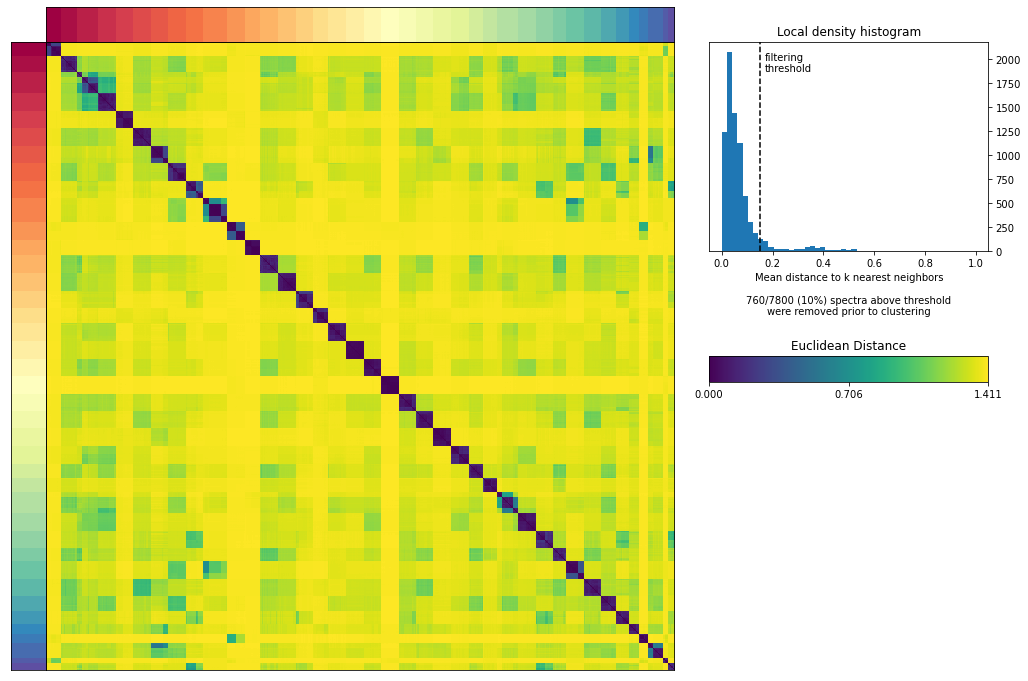

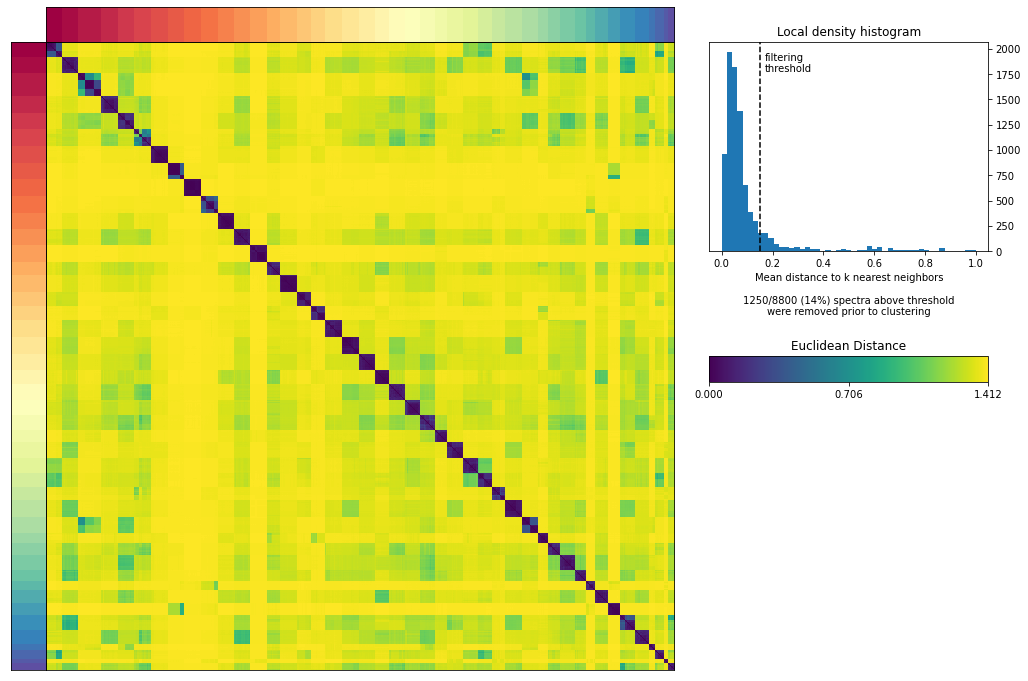

In [92]:
for k in kthresh.keys():
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

In [31]:
kthresh = {39:0.2, 44:0.2}

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


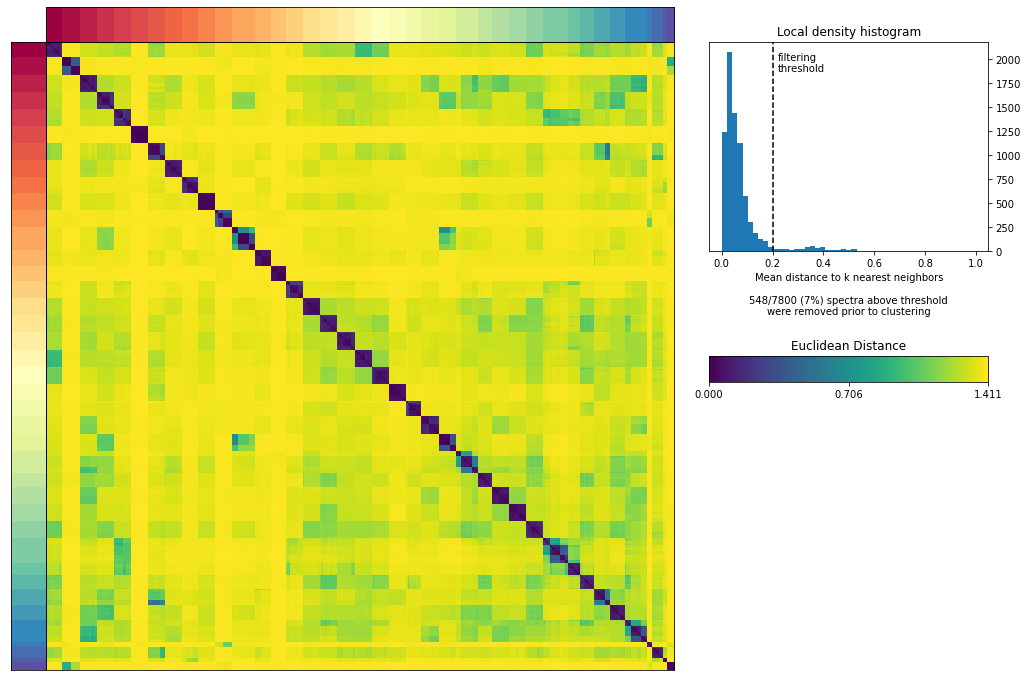

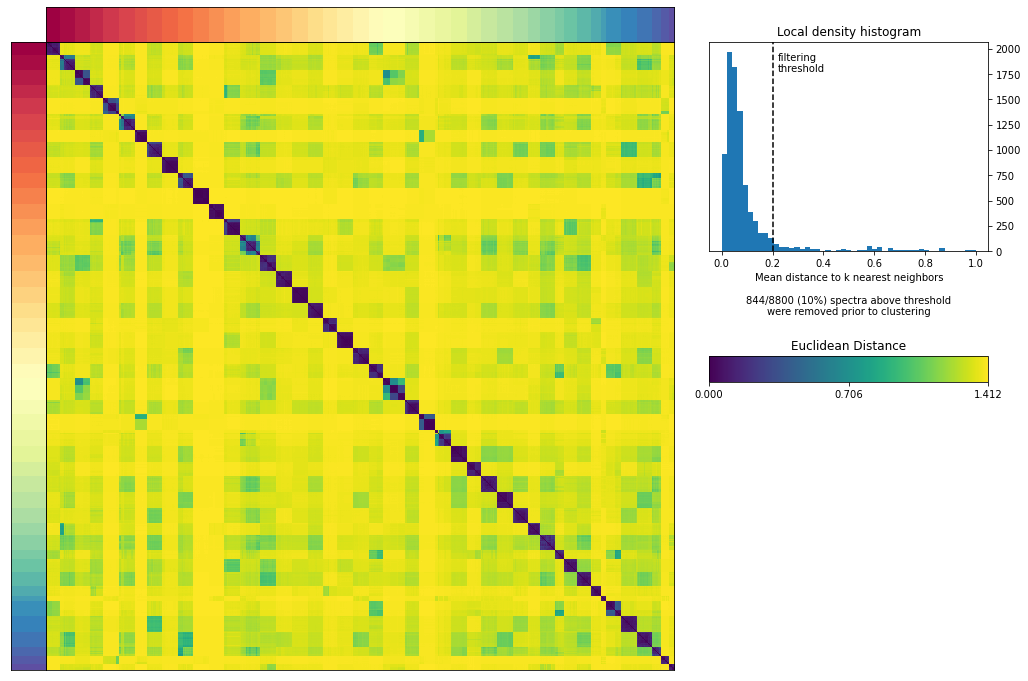

In [94]:
for k in kthresh.keys():
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

## Look at the results for Ks with 200 iterations

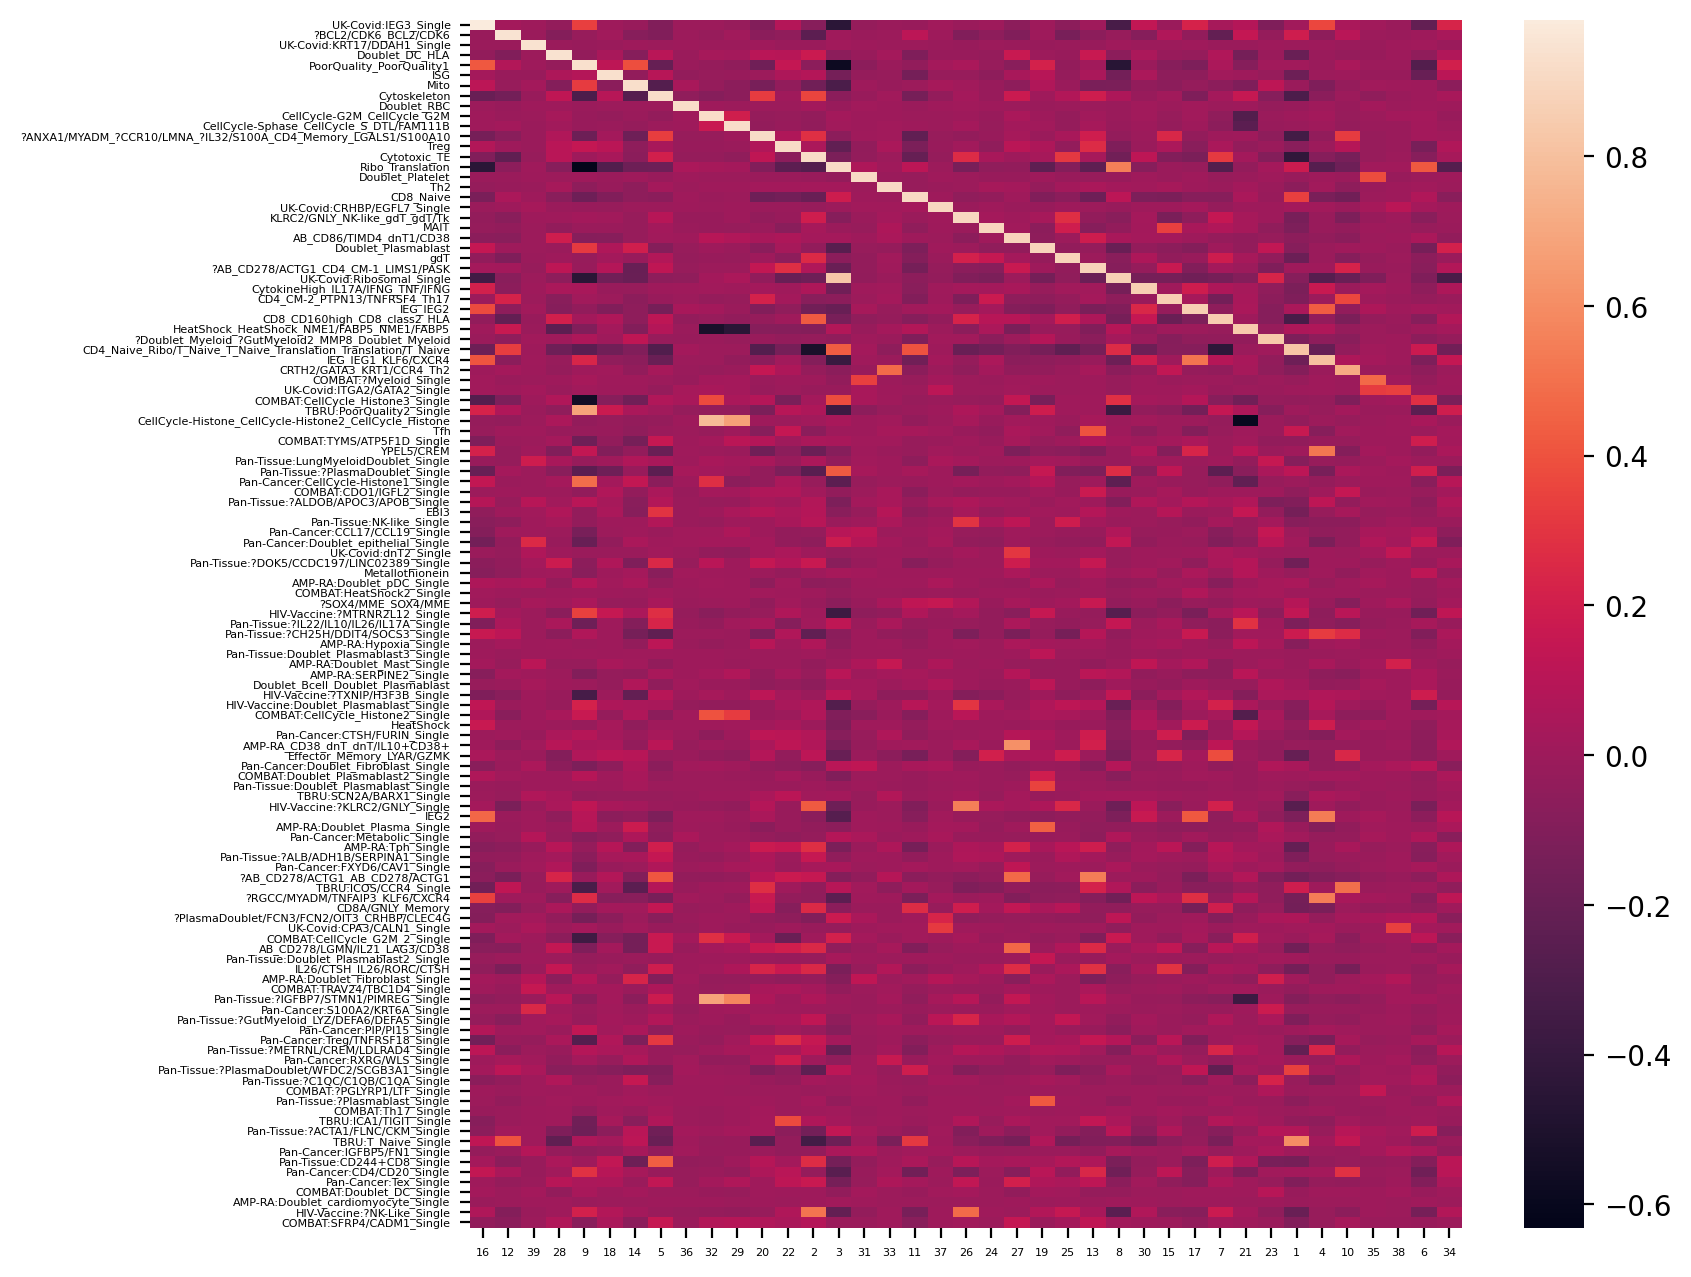

In [32]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=39, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [33]:
res = []
k=39
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
# res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
# res

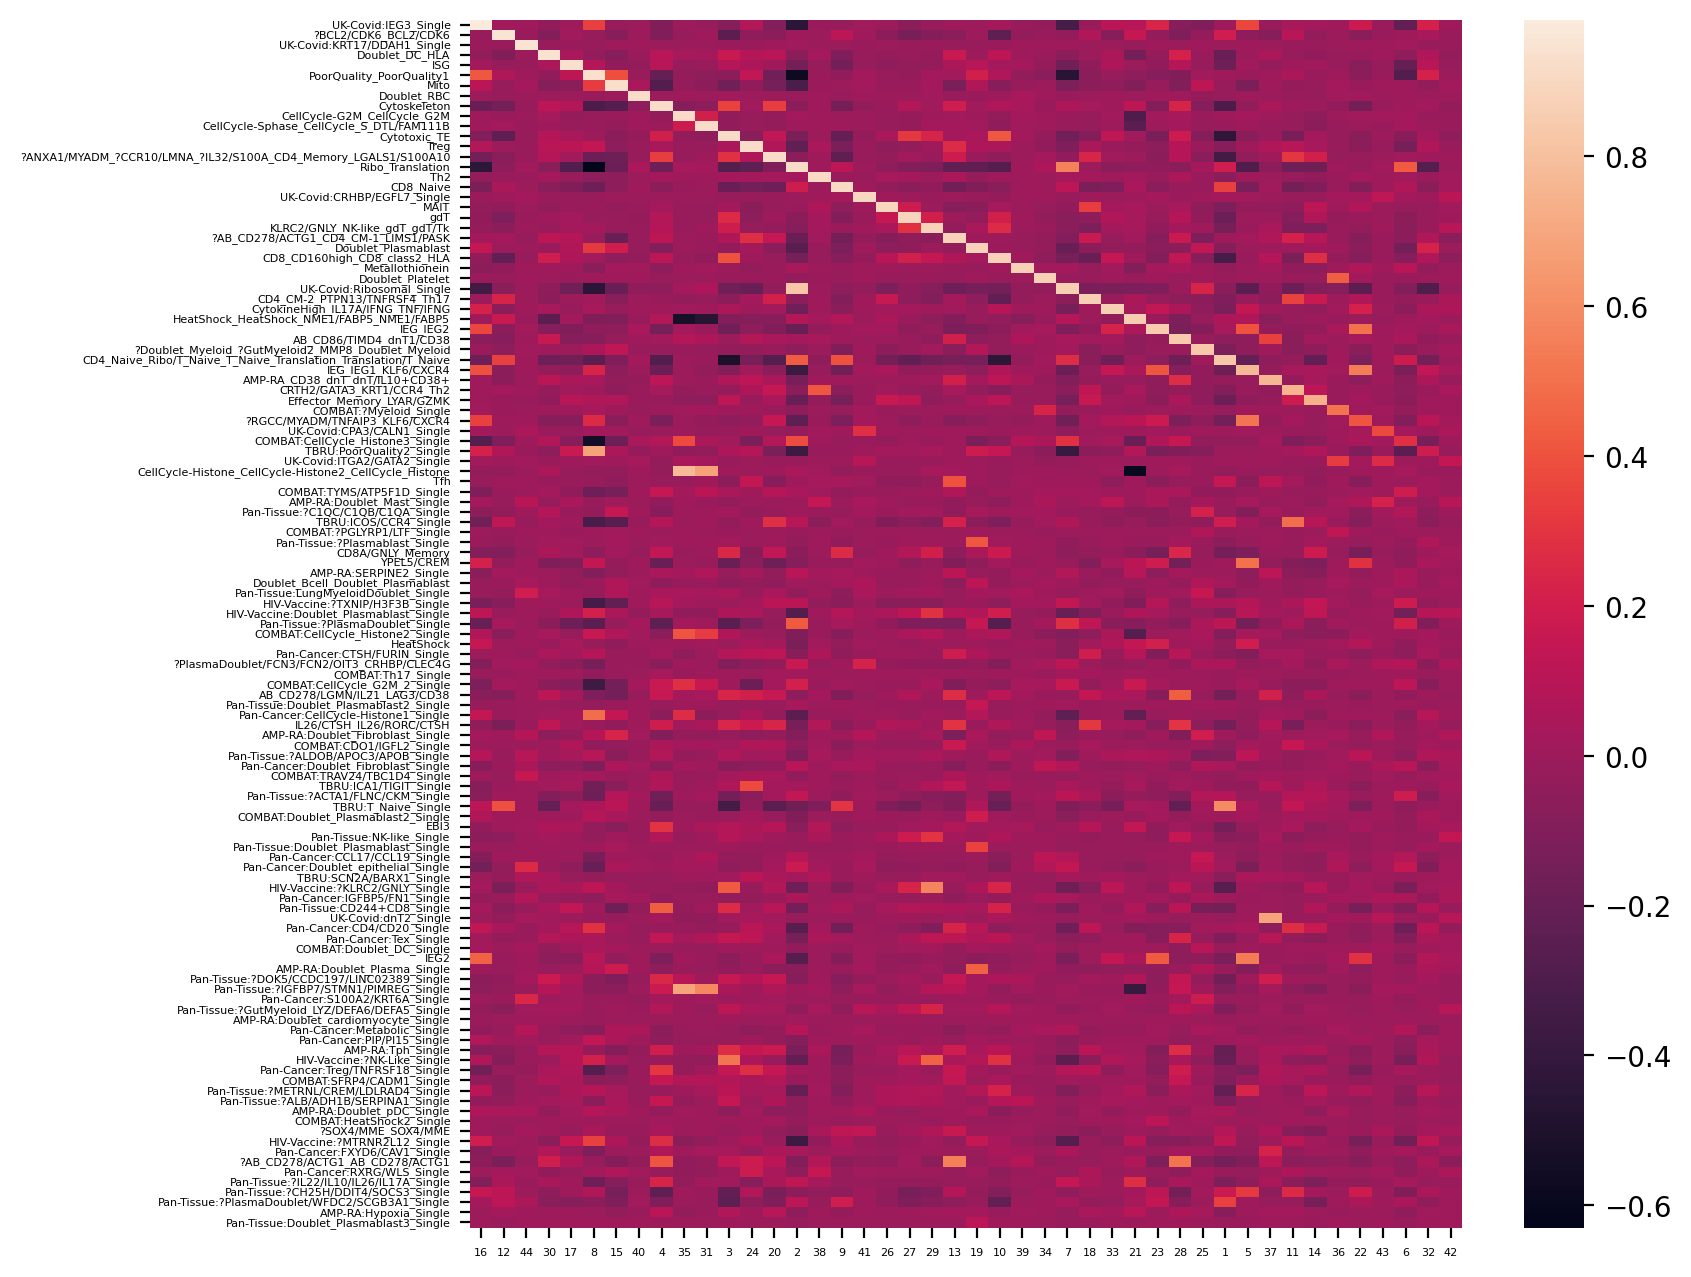

In [51]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=44, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [52]:
# res = []
k=44
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  39                35                             31   
1  44                38                             34   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                             7                      4               4   
1                             7                      4               6   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0

In [36]:
set(mapping_ref[44].loc[mapping_ref[44]['R']>R_thresh, 'X_columns']) - set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns'])


{'AMP-RA_CD38_dnT_dnT/IL10+CD38+',
 'Effector_Memory_LYAR/GZMK',
 'Metallothionein'}

In [37]:
set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns']) - set(mapping_ref[44].loc[mapping_ref[44]['R']>R_thresh, 'X_columns'])


set()

In [38]:
k, usage.shape

(44, (273516, 44))

In [120]:
os.path.abspath(cnmfdir)

'/data/srlab1/TCAT/Data/PerDataset/UKCOVID'

In [121]:
name

'UKCOVID.20231005.Iter200'

In [122]:
os.path.abspath('.')

'/data/srlab1/TCAT/Analysis/PerDataset/UKCOVID'

In [39]:
gep_info = read_dataset_log('GEP_Name')
gep_info.index = gep_info['MetaGep_Name']
gep_info.head()

MetaGep_Name  \
MetaGep_Name                                                                         
CellCycle-G2M_CellCycle_G2M                            CellCycle-G2M_CellCycle_G2M   
ISG                                                                            ISG   
gdT                                                                            gdT   
Metallothionein                                                    Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  CellCycle-Sphase_CellCycle_S_DTL/FAM111B   

                                                            Long_Name  \
MetaGep_Name                                                            
CellCycle-G2M_CellCycle_G2M                      Cell Cycle G2M Phase   
ISG                                       Interferon Stimulated Genes   
gdT                                               Gamma Delta T Blood   
Metallothionein                                       Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B           Cell Cycle S Phase   

                                               Short_Name Needs Review  \
MetaGep_Name                                                             
CellCycle-G2M_CellCycle_G2M                 CellCycle-G2M          NaN   
ISG                                                   ISG          NaN   
gdT                                             gdT-Blood          NaN   
Metallothionein                           Metallothionein          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      CellCycle-S          NaN   

                                                   Class  Num_Datasets Flag  
MetaGep_Name                                                                 
CellCycle-G2M_CellCycle_G2M               Known Activity           7.0  NaN  
ISG                                       Known Activity           7.0  NaN  
gdT                                        Known Lineage           4.0  NaN  
Metallothionein                           Known Activity           5.0  NaN  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Known Activity           7.0  NaN

In [40]:
gep2meta = dict(zip(mapping['Y_columns'], mapping['X_columns']))
meta2rename = dict(zip(gep_info['MetaGep_Name'], gep_info['Short_Name']))
# meta2rename['HIV-Vaccine:?TXNIP/H3F3B_Single'] = 'HIV-Vaccine:?TXNIP/H3F3B_Single'
for key in set(gep2meta.values()).difference(meta2rename.keys()):
    meta2rename[key] = key
gep2rename = {g:meta2rename[gep2meta[g]] for g in gep2meta.keys()}

In [41]:
usage_rename = usage.rename(columns=gep2rename)
spectra_scores_rename = spectra_scores.rename(columns=gep2rename)
spectra_tpm_rename = spectra_tpm.rename(columns=gep2rename)

In [126]:
for dat, lab in [(usage_rename, 'Usage'), (spectra_scores_rename, 'Spectra_Scores'), (spectra_tpm_rename, 'Spectra_TPM')]:
    fn = os.path.join(cnmfdir, name +'.'+lab+'.Relabeled.tsv')
    print(os.path.abspath(fn))
    dat.to_csv(fn, sep='\t')

/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200.Usage.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200.Spectra_Scores.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCOVID.20231005.Iter200.Spectra_TPM.Relabeled.tsv


In [127]:
top_genes_relabed = {}
for g in spectra_scores_rename.columns:
    top_genes_relabed[g] = spectra_scores_rename[g].sort_values(ascending=False).iloc[:50].index
    
top_genes_relabed = pd.DataFrame.from_dict(top_genes_relabed).T

In [43]:
top_genes_relabed

0           1          2   \
CD4-Naive                              CCR7        TCF7       LEF1   
Translation                           RPS18        RPS6      RPL13   
Cytotoxic                            FGFBP2        GZMH       NKG7   
Cytoskeleton                           ACTB       ACTG1       PFN1   
IEG                                   YPEL5     TSC22D3   PPP1R15A   
COMBAT:CellCycle_Histone3_Single    RNPEPL1         SRM      MZT2B   
UK-Covid:Ribosomal_Single             RPL17       EEF1G      TOMM6   
MALAT1                                 MYH9       MACF1      AHNAK   
CD8-Naive                         LINC02446        CD8B     AB_CD8   
CD8_EM                                 CMC1       CD160      EOMES   
Th2                                    KRT1        NEFL      GATA3   
BCL2/CDK6                              CISH      FAM13A      SOCS2   
CD4 TCM                            AB_CD278       LIMS1     IGFBP4   
CD4 TEM                                GZMK    IFNG-AS1       LYAR   
Mito                                 MT-CO2      MT-CYB     MT-CO3   
UK-Covid:IEG3_Single                   KLF6  ATP2B1-AS1      TAGAP   
ISG                                   ISG15         MX1       IFI6   
Th17                                   CCR6  TTC39C-AS1       CTSH   
Doublet-Plasma                       JCHAIN    IGKV3-20       IGKC   
S100A10/LMNA                          CCR10     S100A10      CRIP1   
HeatShock2                            FABP5       HSPD1   HSP90AB1   
RGCC/MYADM                           CDKN1A       KLF10     NFKBIA   
IEG-Tissue                             IER2        EGR1        JUN   
Treg                                  FOXP3       RTKN2      IL2RA   
Doublet-Myeloid                      S100A8      S100A9        LYZ   
MAIT                                SLC4A10     TRAV1-2      KLRB1   
gdT-Blood                             TRDV2       TRGV9       TRDC   
TIMD4/CD38                            TIMD4      HAVCR2       LAG3   
gdT                                   KLRC3       KLRC2    KIR2DL3   
HLA                                 HLA-DRA    HLA-DRB1       CD74   
CellCycle-S                            TYMS         TK1      UHRF1   
TBRU:PoorQuality2_Single            IGLV2-8     IGHV6-1  IGKV2D-30   
High-Cytokine                          CCL4      CCL4L2        TNF   
Doublet-Platelet                       PPBP        NRGN       MYL9   
CellCycle-G2M                         UBE2C        PLK1      CCNB2   
COMBAT:?Myeloid_Single                RGS18       ACRBP    C2orf88   
IL10/CD38                              CAV1       PTPN3      BTNL8   
CCR3+-Th2                             HPGDS   LINC01229     IL17RB   
Metallothionein                        MT1X        MT1E       MT1G   
Doublet-RBC                            HBA1         HBB       HBA2   
UK-Covid:CRHBP/EGFL7_Single           CRHBP        NPR3     MALRD1   
UK-Covid:ITGA2/GATA2_Single          CLEC3B      HS6ST2        KIT   
UK-Covid:CPA3/CALN1_Single             CPA3      CNRIP1     FCER1A   
UK-Covid:KRT17/DDAH1_Single           KRT17       KRT19      DDAH1   

                                            3         4            5   \
CD4-Naive                                 FHIT      SELL          AK5   
Translation                             EEF1A1     RPLP1         RPL3   
Cytotoxic                                 GZMB      PRF1       PRSS23   
Cytoskeleton                            CORO1A      CFL1         CNN2   
IEG                                       JUNB     DUSP1         EIF1   
COMBAT:CellCycle_Histone3_Single         FMNL1     RPL41        RPL39   
UK-Covid:Ribosomal_Single               ATP5PO    RPL36A  RPS10-NUDT3   
MALAT1                                   SYNE2    MALAT1        NEAT1   
CD8-Naive                                 NT5E     CD248    AB_CD45RA   
CD8_EM                                    CD8A      GZMK         GZMM   
Th2                                      FXYD7      IL7R      AB_CD82   
BCL2/CDK6     